## Imports

In [89]:
import csv
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
from matplotlib.pyplot import cm

import numpy as np
import trompy as tp
from datetime import datetime
import pandas as pd
import pickle 

%matplotlib inline


from scipy import stats

In [90]:
def extract_event_fn(filename): 
    '''
    function to extract framenumber of events (licks and pump_on) in framenumber
    
    args
    filename - string 
    
    returns 
    licks_fn - lits of integers
        framenumber of licks
    pump_on_fn - list of integers 
        framenumber when pump turns on
    
    '''
    df= pd.read_csv(filename)
    
    #Extracts pump on framenumber
    pump_fn = list(df[df['Item1'] == 'pump_on']['Item2.Item2'])
    
    
    #Extracts licks framenumber
    licks_fn = list (df[df['Item1']== 'Lick']['Item2.Item2'])

      
    return pump_fn, licks_fn
        


In [91]:
def get_hit_miss_trial (pump_fn, licks_fn): 
    '''
    function to get hit and miss trials
    
    arg 
    pump_fn - list of integers
        framenumber for when the pump turns on 
    licks_fn - list of integers
        framenumber for all licks
    triallenght - int float (optional, default set to 100 frames (10sec))
    
    returns 
    hit_trial - list of int 
        pump on frame number in hit trials (lick > 0)
    miss_trial - list of int 
        pump on frame number in missed trials (lick = 0)
    
    '''
    hit_trial=[]
    miss_trial=[]
    for p in pump_fn: 
        temp=[]
        for lick in licks_fn: 
            if lick > p and lick < p + 100: 
                temp.append(lick)
            
        if len(temp)> 0:
            hit_trial.append(p)
        if len(temp) == 0: 
            miss_trial.append(p)
    return hit_trial, miss_trial

In [92]:
def get_licks_trial (pump_fn, licks_fn, triallength=100):
    '''
    function to get licks within one trial 
    licks aligned to pump on (pump_fn)
    
    arg 
    pump_fn - list of integers
        framenumber for when the pump turns on 
    licks_fn - list of integers
        framenumber for all licks
    triallenght - int float (optional, default set to 100 frames (10sec))
    
    returns 
    licks_trial - list of list of integers
        list of all licks in all trials aligned to pump on (in frames)
    licks_all_trial - list of integers
        number of licks of each trial 
    licks_hit_trial - list of integers 
        number of licks per trial for hit trials 
    latency - list of integers
        latency to first lick after pump on (in frames)
        
    
    '''

    # All licks aligned to pump on 
    licks_trial=[]
    for p in pump_fn:
        temp=[]
        for lick in licks_fn: 
            if lick > p and lick < p + 120:
                temp.append(lick - p)
        licks_trial.append(temp)
        
        
    #licks per trial (all and hit trials) aligned to pump on 
    licks_all_trial=[]
    licks_hit_trial=[]
    for trial in licks_trial: 
        licks_all_trial.append(len(trial))
        if len(trial) > 0: 
            licks_hit_trial.append(len(trial))
            
            
    #Latency to first lick after pump on
    temp_latency=[]
    latency_all_temp=[]
    for trial in licks_trial:
        latency_all_temp.append(trial[:1])
        if len(trial) > 0: 
            temp_latency.append(trial[:1])
        
            
    
    latency=[trial for sublist in temp_latency for trial in sublist] #List comprehension to convert list of lists to flat list     
    
        
    return licks_trial, licks_all_trial, licks_hit_trial, latency, latency_all_temp

In [93]:
def get_binned_latency(latency_all): 
    '''
    function to get mean latency for binned trials  
    bins = 10 trials 
    
    args
    latency_all - list of lists of int
        list all the latencies to first lick in each trial. if no lick list is empty 
        
    returns 
    latency1/2/3/4 - float 
        the mean latency for hit trials in 4 different bins (10 trial per bin)
    '''
    bin1=tp.flatten_list(latency_all[:10])
    bin2=tp.flatten_list(latency_all[10:20])
    bin3=tp.flatten_list(latency_all[20:30])
    bin4=tp.flatten_list(latency_all[30:])

    latency1=np.mean(bin1)
    latency2=np.mean(bin2)
    latency3=np.mean(bin3)
    latency4=np.mean(bin4)
    
    return latency1,latency2,latency3,latency4

In [94]:
def get_grouped_latencybin(diet,solution, session):

    bin1=[]
    bin2=[]
    bin3=[]
    bin4=[]

    for key in all_data.keys():
        d=all_data[key]
        if d['solution']== solution and d['diet'] == diet and d['session'] == session and len(d['pump_fn']) > 30: 
            if d['latency1'] > 0:
                bin1.append(d['latency1'])
            if d['latency2'] > 0:
                bin2.append(d['latency2'])
            if d['latency3'] > 0:
                bin3.append(d['latency3'])
            if d['latency4'] > 0:
                bin4.append(d['latency4'])
        


    b1_m=np.mean(bin1)
    b1_E=np.std(bin1, ddof=1) / np.sqrt(np.size(bin1))
    b2_m=np.mean(bin2)
    b2_E=np.std(bin2, ddof=1) / np.sqrt(np.size(bin2))
    b3_m=np.mean(bin3)
    b3_E=np.std(bin3, ddof=1) / np.sqrt(np.size(bin3))
    b4_m=np.mean(bin4)
    b4_E=np.std(bin4, ddof=1) / np.sqrt(np.size(bin4))
    
    mean=[b1_m,b2_m,b3_m,b4_m]
    error=[b1_E,b2_E,b3_E,b4_E]
    
    
    return mean,error
    

In [95]:
def get_binned_hit (data): 
    
    bin1=data[:10]
    bin2=data[10:20]
    bin3=data[20:30]
    bin4=data[30:]


    hit1=[]
    miss1=[]
    for trial in bin1: 
        if len(trial)>0: 
            hit1.append(trial[:1])
        elif len(trial)==0: 
            miss1.append(trial)
        
    try: 
        p_bin1 =(len(hit1)/(len(hit1)+len(miss1)))*100
    except ZeroDivisionError:
        p_bin1=np.nan

    hit2=[]
    miss2=[]
    for trial in bin2: 
        if len(trial)>0: 
            hit2.append(trial[:1])
        elif len(trial)==0: 
            miss2.append(trial)
            
    try: 
        p_bin2 =(len(hit2)/(len(hit2)+len(miss2)))*100
    except ZeroDivisionError:
        p_bin2=np.nan

    hit3=[]
    miss3=[]
    for trial in bin3: 
        if len(trial)>0: 
            hit3.append(trial[:1])
        elif len(trial)==0: 
            miss3.append(trial)
            
    try: 
        p_bin3 =(len(hit3)/(len(hit3)+len(miss3)))*100
    except ZeroDivisionError:
        p_bin3=np.nan
    

    hit4=[]
    miss4=[]
    for trial in bin4:
        if len(trial)>0: 
            hit4.append(trial[:1])
        elif len(trial)==0: 
            miss4.append(trial)
            
    try: 
        p_bin4 =(len(hit4)/(len(hit4)+len(miss4)))*100
    except ZeroDivisionError:
        p_bin4=np.nan
            
    
    
    return p_bin1,p_bin2,p_bin3,p_bin4

In [96]:
def make_barscatter(data, ax=None, barlabels=['PR','PRNR','NR','NRPR'], barfacecolor = ['darkcyan','c', 'black', 'grey']):
    
    '''
    function to make barscatter
    
    arg 
    data - list of lists of floats
        The data you want to put into the plot
    barlabels - list of strings
        labels for the bars plotted (optional - defaulte : 'PR','PRNR','NR','NRPR' )
    barfacecolors - list of strings
        colors for the bars (optional- default: ['darkcyan','c', 'black', 'grey'])
    
    
    returns 
    ax - ax to put into sublot
    
    '''
    if ax == None: 
        f,ax = plt.subplots()
        
    tp.barscatter(data, 
#                   paired= True,
                  barfacecolor=barfacecolor,
                  barlabels=barlabels,
                  barlabeloffset=0.04,
                  barfacecolor_option='individual',
                  fontsize = 13,
                  scattersize=110,
                  scatteralpha=0.7,
                  spaced=True,
                  linewidth=1.5,
                  ax=ax)
    
    return ax
    

In [97]:
def get_cumulative_licks(licks_fn): 
    '''
    function to get cumulative licks. 
    lick frame number put into bins and calculated as cumulative
    
    args 
    licks_fn - list of floats 
        the framenumber of all licks in the session 
    bins - float - optional default set to 100 (10 sec)
        size of bins
        
    returns
    lickcum - array of cumulative licks 
    lickbin - array of bins '''
    
    bins=list(range(0,12900,10))
    licks, b = np.histogram(licks_fn, bins=bins)
    lickcum = np.cumsum(licks)
    lickbin = b[1:]
    
    return lickcum, lickbin

In [98]:
def get_grouped_data(dictionary, solution, data ):
    '''
    function to group data and get output from animals grouped into PR, PRNR, NR and NRPR
    
    args
    dictionary - name of dictionaty (eks behav_data)
    solution - string 
        the name of the soltuion, given as a key in the dictionaty (eks 'Ensure')
    data - string
        name of the data/output you want as output (eks 'total licks') 
        
        
        
    '''
    
    PR=[]
    PRNR=[]
    
    NR=[]
    NRPR=[]
    
    for mouse in mice: 
        temp_PR=[]
        temp_PRNR=[]
        
        temp_NR=[]
        temp_NRPR=[]
        
        for key in dictionary.keys():
            d=dictionary[key]
            
            if d['mouse']== mouse and d['solution']==solution and d['diet']== 'PR': 
                temp_PR.append(d[data])
                
            elif d['mouse']==mouse and d['solution']==solution and d['diet']== 'NR':
                temp_NR.append(d[data])
            elif d['mouse']==mouse and d['solution']==solution and d['diet']== 'PRNR':
                temp_PRNR.append(d[data])
            elif d['mouse']==mouse and d['solution']==solution and d['diet']== 'NRPR':
                temp_NRPR.append(d[data])
        if len(temp_PR)> 0:
            PR.append(np.mean(temp_PR))
        if len(temp_NR)>0:
            NR.append(np.mean(temp_NR))
        if len(temp_PRNR)>0:
            PRNR.append(np.mean(temp_PRNR))
        if len(temp_NRPR)>0:
            NRPR.append(np.mean(temp_NRPR))
            
    return PR, PRNR, NR, NRPR
                
        

In [99]:
def grouped_by_session(dictionary, solution,session, output):
    
    
    PR=[]
    PRNR=[]
    
    NR=[]
    NRPR=[]
    
    for key in dictionary.keys():
            d=dictionary[key]
            
            if d['solution']== solution and d['diet'] == 'PR' and d['session'] == session: 
                PR.append(np.mean(d[output]))
            elif d['solution']== solution and d['diet'] == 'PRNR' and d['session'] == session: 
                PRNR.append(np.mean(d[output]))
            elif d['solution']== solution and d['diet'] == 'NR' and d['session'] == session: 
                NR.append(np.mean(d[output]))
            elif d['solution']== solution and d['diet'] == 'NRPR' and d['session'] == session: 
                NRPR.append(np.mean(d[output]))
                
                
    return PR, PRNR, NR, NRPR
        
   

## Metafile reader

In [100]:
rows,header=tp.metafilereader('C:\\Users\\mko102\\UiT Office 365\\O365-Pipette 2 - Dokumenter\\People\\Mette\\GitHub\\2P\\Metafile_VGP2.2.xls',sheetname='Behavior')
# rows_homecage,header=tp.metafilereader('C:\\Users\\mko102\\UiT Office 365\\O365-Pipette 2 - Dokumenter\\People\\Mette\\GitHub\\2P\\Metafile_VGP2.2.xls',sheetname='Homecage')
folder= 'C:\\Users\\mko102\\UiT Office 365\\O365-Pipette 2 - Dokumenter\\People\\Mette\\GitHub\\2P\\VGP2\\Bonsai\\'

File is excel file. Making csv metafile first


## Dictionary

In [101]:
all_data={}

for row in rows: 
    try:
        key=row[0]+ '_' + row[4]
    
        pump_fn, licks_fn = extract_event_fn(folder+row[1])
        hit_trial, miss_trial = get_hit_miss_trial(pump_fn, licks_fn)
        licks_trial, licks_all_trial, licks_hit_trial, latency, latency_all = get_licks_trial(pump_fn, licks_fn)
        cumlicks, bins = get_cumulative_licks(licks_fn)
        
        latency1, latency2, latency3, latency4 = get_binned_latency(latency_all)
#         if len(pump_fn) > 30: 

        hit1, hit2, hit3, hit4 = get_binned_hit(latency_all)
    
        
    
        all_data[key]={}

        all_data[key]['mouse']=row[0]
        all_data[key]['diet']=row[7]
        all_data[key]['solution']=row[8]
        all_data[key]['session']=row[10]
    
#         all_data[key]['file']=row[1]
#         all_data[key]['licks_fn']= licks_fn
        all_data[key]['pump_fn']= pump_fn
        all_data[key]['licks trial']= licks_trial
        all_data[key]['number of trials']=len(pump_fn)
        all_data[key]['total licks']=len(licks_fn)
        all_data[key]['hit trial'] = len(hit_trial)
        all_data[key]['% hit']=(len(hit_trial)/(len(pump_fn))*100)
        all_data[key]['miss trials']= len(miss_trial)
        all_data[key]['licks per trial']= np.mean(licks_all_trial)
        all_data[key]['licks hit trial']= np.mean(licks_hit_trial)
        all_data[key]['latency']= np.mean(latency)
        
        all_data[key]['latency all']=latency_all
        all_data[key]['latency1']=latency1
        all_data[key]['latency2']=latency2
        all_data[key]['latency3']=latency3
        all_data[key]['latency4']=latency4
        
        all_data[key]['hit 1']= hit1
        all_data[key]['hit 2']= hit2
        all_data[key]['hit 3']= hit3
        all_data[key]['hit 4']= hit4
        
        
        all_data[key]['cumulative licks']=cumlicks
        all_data[key]['lick bins']=bins
        
    
    except FileNotFoundError: 
        print('Cannot find file for', key)

Cannot find file for _


In [102]:

with open('..//output//behavdata.pickle', 'wb') as file:
    pickle.dump(all_data, file, protocol=pickle.HIGHEST_PROTOCOL)

with open('..//output//behavdata.pickle', 'rb') as file:
    b = pickle.load(file)

In [103]:
mice=[]

for key in all_data.keys(): 
    d=all_data[key]
    mouseid=d['mouse']
    if mouseid not in mice: mice.append(mouseid)


for m in mice: 
    if m == 'VGP305':
        mice.remove(m)



mice

['VGP118',
 'VGP202',
 'VGP203',
 'VGP204',
 'VGP302',
 'VGP310',
 'VGP306',
 'VGP307',
 'VGP402',
 'VGP403',
 'VGP404',
 'VGP501',
 'VGP502',
 'VGP503',
 'VGP504',
 'VGP505',
 'VGP506',
 'VGP509']

## Total number of licks

Ensure, casein and maltodextrin

In [104]:

# Total licks Casein
cas_PR,cas_PRNR,cas_NR,cas_NRPR= get_grouped_data(all_data, 'Cas', 'total licks')
# Total licks Maltodextrin
malt_PR,malt_PRNR,malt_NR,malt_NRPR= get_grouped_data(all_data, 'Malt.', 'total licks')

#Total licks Protein paired
ppaired_PR,ppaired_PRNR,ppaired_NR,ppaired_NRPR= get_grouped_data(all_data, 'ppaired', 'total licks')
mpaired_PR,mpaired_PRNR,mpaired_NR,mpaired_NRPR= get_grouped_data(all_data, 'mpaired', 'total licks')

Could not space all sets of points.
Could not space all sets of points.
Could not space all sets of points.
Could not space all sets of points.
Could not space all sets of points.
Could not space all sets of points.
Could not space all sets of points.
Could not space all sets of points.


Text(0.5, 1.0, 'Maltodextrin')

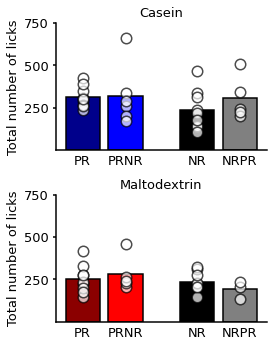

In [105]:
# Making figure for total licks - Mean per animal

f,ax=plt.subplots(figsize=(4.5,5), ncols=1, nrows=2, sharey='row')
f.subplots_adjust(wspace=0.15,hspace=0.35, bottom=0.05, left=0.25)


colors_C=['darkblue','blue','black', 'grey']
colors_M=['darkred','red','black', 'grey']

ax[0]= make_barscatter([[cas_PR,cas_PRNR],[cas_NR,cas_NRPR]], ax=ax[0],barfacecolor= colors_C)
ax[1] = make_barscatter([[malt_PR,malt_PRNR],[malt_NR,malt_NRPR]], ax=ax[1],barfacecolor= colors_M)



ax[0].set_ylabel('Total number of licks',fontsize = 13)
ax[0].set_yticks([250,500,750])
ax[0].set_yticklabels([250,500,750], fontsize = 13)

ax[1].set_ylabel('Total number of licks',fontsize = 13)
ax[1].set_yticks([250,500,750])
ax[1].set_yticklabels([250,500,750], fontsize = 13)


ax[0].set_title('Casein', fontsize =13)
ax[1].set_title('Maltodextrin', fontsize =13)







## Kool-Aid test

Could not space all sets of points.
Could not space all sets of points.
Could not space all sets of points.
Could not space all sets of points.
Could not space all sets of points.
Could not space all sets of points.
Could not space all sets of points.
Could not space all sets of points.
Could not space all sets of points.
Could not space all sets of points.
Could not space all sets of points.
Could not space all sets of points.
Could not space all sets of points.
Could not space all sets of points.
Could not space all sets of points.
Could not space all sets of points.


Text(0.5, 1.0, 'Carbohydrate-paired')

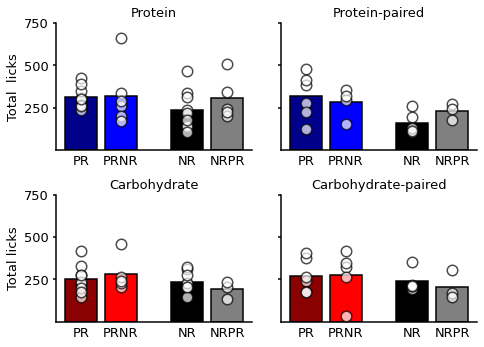

In [106]:
# Making figure for total licks - Mean per animal

f,ax=plt.subplots(figsize=(9,5), ncols=2, nrows=2, sharey='row')
f.subplots_adjust(wspace=0.15,hspace=0.35, bottom=0.05, left=0.25)


colors_C=['darkblue','blue','black', 'grey']

colors_M=['darkred','red','black', 'grey']

ax[0,0]= make_barscatter([[cas_PR,cas_PRNR],[cas_NR,cas_NRPR]], ax=ax[0,0],barfacecolor= colors_C)
ax[0,1]= make_barscatter([[ppaired_PR,ppaired_PRNR],[ppaired_NR,ppaired_NRPR]], ax=ax[0,1],barfacecolor= colors_C)
ax[1,0] = make_barscatter([[malt_PR,malt_PRNR],[malt_NR,malt_NRPR]], ax=ax[1,0],barfacecolor= colors_M)
ax[1,1] = make_barscatter([[mpaired_PR,mpaired_PRNR],[mpaired_NR,mpaired_NRPR]], ax=ax[1,1],barfacecolor= colors_M)






# colors_M=['darkred','red','black', 'grey']

# ax[0]= make_barscatter([[cas_PR,cas_PRNR],[cas_NR,cas_NRPR]], ax=ax[0],barfacecolor= colors_C)
# ax[1] = make_barscatter([[malt_PR,malt_PRNR],[malt_NR,malt_NRPR]], ax=ax[1],barfacecolor= colors_M)


ax[0,0].set_ylabel('Total  licks',fontsize = 13)
ax[0,0].set_yticks([250,500,750])
ax[0,1].set_yticks([250,500,750])
ax[0,0].set_yticklabels([250,500,750], fontsize = 13)

ax[1,0].set_ylabel('Total licks',fontsize = 13)
ax[1,0].set_yticks([250,500,750])
ax[1,1].set_yticks([250,500,750])
ax[1,0].set_yticklabels([250,500,750], fontsize = 13)

ax[0,0].set_title('Protein', fontsize =13)
ax[0,1].set_title('Protein-paired', fontsize =13)
ax[1,0].set_title('Carbohydrate', fontsize =13)
ax[1,1].set_title('Carbohydrate-paired', fontsize =13)


# f.savefig('C:\\Users\\mko102\\GitHub\\VGP\\output\\total_licks_kool-aid.png')


Could not space all sets of points.
Could not space all sets of points.
Could not space all sets of points.
Could not space all sets of points.


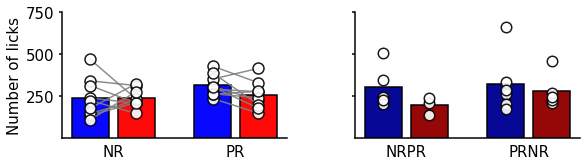

In [107]:
# Figure NR- cas/malt - PR- cas/malt 

f,ax=plt.subplots(figsize=(9,3), ncols=2, sharey=False)
f.subplots_adjust(wspace=0.3, bottom=0.3, left=0.1)

colors_1=['#0808FF','#FF0808','#0808FF','#FF0808']
colors_2=['#080896','#960808','#080896','#960808']





tp.barscatter([[cas_NR,malt_NR],[cas_PR,malt_PR]], 
              paired= True,
              barfacecolor=colors_1,
              barfacecolor_option="individual",
              fontsize = 15,
              scattersize=110,
              scatteralpha=0.9,
              spaced=True,
              linewidth=1.5,
              ax=ax[0],
              grouplabel=['NR','PR'],
              show_legend=False)


# ax[1]= make_barscatter([[cas_NRPR,malt_NRPR],[cas_PRNR,malt_PRNR]], ax=ax[1],barfacecolor= colors_2, barlabels=labels)

tp.barscatter([[cas_NRPR,malt_NRPR],[cas_PRNR,malt_PRNR]], 
#               paired= True,
              barfacecolor=colors_2,
              barfacecolor_option="individual",
              fontsize = 15,
              scattersize=110,
              scatteralpha=0.9,
              spaced=True,
              linewidth=1.5,
              ax=ax[1],
              grouplabel=['NRPR','PRNR'],
              show_legend=False)


ax[0].set_ylabel('Number of licks',fontsize = 15)
ax[0].set_yticks([250,500,750])
ax[0].set_yticklabels([250,500,750], fontsize = 15)


ax[1].set_yticks([250,500,750])
ax[1].set_yticklabels([])



colors = {'Casein':'#080896', 'Maltodextrin':'#960808'}         
labels = list(colors.keys())
handles = [plt.Rectangle((0,0),0.5,0.5, color=colors[label]) for label in labels]
# ax[0].legend(handles, labels, fontsize=13, frameon=False)



# f.savefig('C:\\Users\\mko102\\GitHub\\VGP\\output\\total_licks_3.png')



## Licks per trial (all)

In [108]:
cas_PR,cas_PRNR,cas_NR,cas_NRPR= get_grouped_data(all_data, 'Cas', 'licks per trial')
malt_PR,malt_PRNR,malt_NR,malt_NRPR= get_grouped_data(all_data, 'Malt.', 'licks per trial')

#Total licks Protein paired
ppaired_PR,ppaired_PRNR,ppaired_NR,ppaired_NRPR= get_grouped_data(all_data, 'ppaired', 'licks per trial')
mpaired_PR,mpaired_PRNR,mpaired_NR,mpaired_NRPR= get_grouped_data(all_data, 'mpaired', 'licks per trial')



## Figures licks per trial

Could not space all sets of points.
Could not space all sets of points.
Could not space all sets of points.
Could not space all sets of points.
Could not space all sets of points.
Could not space all sets of points.
Could not space all sets of points.
Could not space all sets of points.
Could not space all sets of points.
Could not space all sets of points.
Could not space all sets of points.
Could not space all sets of points.
Could not space all sets of points.
Could not space all sets of points.
Could not space all sets of points.
Could not space all sets of points.


Text(0.5, 1.0, 'Carbohydrate-paired')

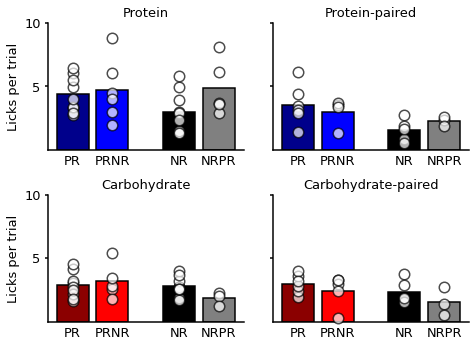

In [110]:
# Making figure for total licks - Mean per animal

f,ax=plt.subplots(figsize=(9,5), ncols=2, nrows=2, sharey='row')
f.subplots_adjust(wspace=0.15,hspace=0.35, bottom=0.05, left=0.25)


colors_C=['darkblue','blue','black', 'grey']

colors_M=['darkred','red','black', 'grey']

ax[0,0]= make_barscatter([[cas_PR,cas_PRNR],[cas_NR,cas_NRPR]], ax=ax[0,0],barfacecolor= colors_C)
ax[0,1]= make_barscatter([[ppaired_PR,ppaired_PRNR],[ppaired_NR,ppaired_NRPR]], ax=ax[0,1],barfacecolor= colors_C)
ax[1,0] = make_barscatter([[malt_PR,malt_PRNR],[malt_NR,malt_NRPR]], ax=ax[1,0],barfacecolor= colors_M)
ax[1,1] = make_barscatter([[mpaired_PR,mpaired_PRNR],[mpaired_NR,mpaired_NRPR]], ax=ax[1,1],barfacecolor= colors_M)






# colors_M=['darkred','red','black', 'grey']

# ax[0]= make_barscatter([[cas_PR,cas_PRNR],[cas_NR,cas_NRPR]], ax=ax[0],barfacecolor= colors_C)
# ax[1] = make_barscatter([[malt_PR,malt_PRNR],[malt_NR,malt_NRPR]], ax=ax[1],barfacecolor= colors_M)


ax[0,0].set_ylabel('Licks per trial',fontsize = 13)
ax[0,0].set_yticks([5,10])
ax[0,1].set_yticks([5,10])
ax[0,0].set_yticklabels([5,10], fontsize = 13)

ax[1,0].set_ylabel('Licks per trial',fontsize = 13)
ax[1,0].set_yticks([5,10])
ax[1,1].set_yticks([5,10])
ax[1,0].set_yticklabels([5,10], fontsize = 13)

ax[0,0].set_title('Protein', fontsize =13)
ax[0,1].set_title('Protein-paired', fontsize =13)
ax[1,0].set_title('Carbohydrate', fontsize =13)
ax[1,1].set_title('Carbohydrate-paired', fontsize =13)


# f.savefig('C:\\Users\\mko102\\GitHub\\VGP\\output\\total_licks_kool-aid.png')

Could not space all sets of points.
Could not space all sets of points.
Could not space all sets of points.
Could not space all sets of points.


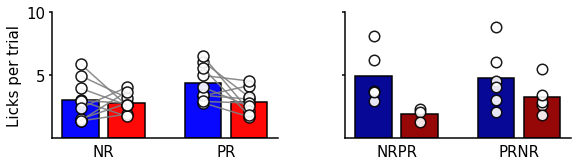

In [112]:
f,ax=plt.subplots(figsize=(9,3), ncols=2, sharey=False)
f.subplots_adjust(wspace=0.3, bottom=0.3, left=0.1)

colors_1=['#0808FF','#FF0808','#0808FF','#FF0808']
colors_2=['#080896','#960808','#080896','#960808']





tp.barscatter([[cas_NR,malt_NR],[cas_PR,malt_PR]], 
              paired= True,
              barfacecolor=colors_1,
              barfacecolor_option="individual",
              fontsize = 15,
              scattersize=110,
              scatteralpha=0.9,
              spaced=True,
              linewidth=1.5,
              ax=ax[0],
              grouplabel=['NR','PR'],
              show_legend=False)


# ax[1]= make_barscatter([[cas_NRPR,malt_NRPR],[cas_PRNR,malt_PRNR]], ax=ax[1],barfacecolor= colors_2, barlabels=labels)

tp.barscatter([[cas_NRPR,malt_NRPR],[cas_PRNR,malt_PRNR]], 
#               paired= True,
              barfacecolor=colors_2,
              barfacecolor_option="individual",
              fontsize = 15,
              scattersize=110,
              scatteralpha=0.9,
              spaced=True,
              linewidth=1.5,
              ax=ax[1],
              grouplabel=['NRPR','PRNR'],
              show_legend=False)


ax[0].set_ylabel('Licks per trial',fontsize = 15)
ax[0].set_yticks([5,10])
ax[0].set_yticklabels([5,10], fontsize = 15)


ax[1].set_yticks([5,10])
ax[1].set_yticklabels([])



colors = {'Casein':'#080896', 'Maltodextrin':'#960808'}         
labels = list(colors.keys())
handles = [plt.Rectangle((0,0),0.5,0.5, color=colors[label]) for label in labels]
# ax[0].legend(handles, labels, fontsize=13, frameon=False)



# f.savefig('C:\\Users\\mko102\\GitHub\\VGP\\output\\total_licks_3.png')

## % of hit trials

In [71]:

cas_PR,cas_PRNR,cas_NR,cas_NRPR= get_grouped_data(all_data, 'Cas', '% hit')
malt_PR,malt_PRNR,malt_NR,malt_NRPR= get_grouped_data(all_data, 'Malt.', '% hit')

#Total licks Protein paired
ppaired_PR,ppaired_PRNR,ppaired_NR,ppaired_NRPR= get_grouped_data(all_data, 'ppaired', '% hit')
mpaired_PR,mpaired_PRNR,mpaired_NR,mpaired_NRPR= get_grouped_data(all_data, 'mpaired', '% hit')

Could not space all sets of points.
Could not space all sets of points.
Could not space all sets of points.
Could not space all sets of points.
Could not space all sets of points.
Could not space all sets of points.
Could not space all sets of points.
Could not space all sets of points.
Could not space all sets of points.
Could not space all sets of points.
Could not space all sets of points.
Could not space all sets of points.
Could not space all sets of points.
Could not space all sets of points.
Could not space all sets of points.
Could not space all sets of points.


Text(0.5, 1.0, 'Carbohydrate-paired')

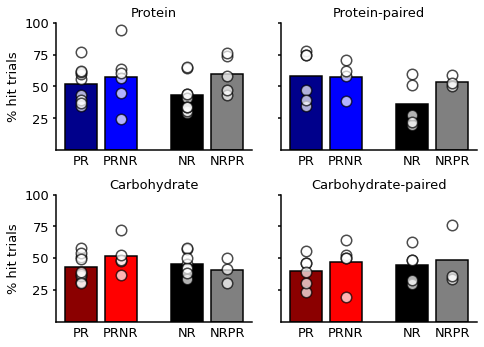

In [73]:
# Making figure for total licks - Mean per animal

f,ax=plt.subplots(figsize=(9,5), ncols=2, nrows=2, sharey='row')
f.subplots_adjust(wspace=0.15,hspace=0.35, bottom=0.05, left=0.25)


colors_C=['darkblue','blue','black', 'grey']

colors_M=['darkred','red','black', 'grey']

ax[0,0]= make_barscatter([[cas_PR,cas_PRNR],[cas_NR,cas_NRPR]], ax=ax[0,0],barfacecolor= colors_C)
ax[0,1]= make_barscatter([[ppaired_PR,ppaired_PRNR],[ppaired_NR,ppaired_NRPR]], ax=ax[0,1],barfacecolor= colors_C)
ax[1,0] = make_barscatter([[malt_PR,malt_PRNR],[malt_NR,malt_NRPR]], ax=ax[1,0],barfacecolor= colors_M)
ax[1,1] = make_barscatter([[mpaired_PR,mpaired_PRNR],[mpaired_NR,mpaired_NRPR]], ax=ax[1,1],barfacecolor= colors_M)




ax[0,0].set_ylabel('% hit trials',fontsize = 13)
ax[0,0].set_yticks([25,50,75,100])
ax[0,1].set_yticks([25,50,75,100])
ax[0,0].set_yticklabels([25,50,75,100], fontsize = 13)

ax[1,0].set_ylabel('% hit trials',fontsize = 13)
ax[1,0].set_yticks([25,50,75,100])
ax[1,1].set_yticks([25,50,75,100])
ax[1,0].set_yticklabels([25,50,75,100], fontsize = 13)



ax[0,0].set_title('Protein', fontsize =13)
ax[0,1].set_title('Protein-paired', fontsize =13)
ax[1,0].set_title('Carbohydrate', fontsize =13)
ax[1,1].set_title('Carbohydrate-paired', fontsize =13)


### % hit trials binned grouped by session

In [87]:
def group_hit_binned(diet, solution, session):
    bin1=[]
    bin2=[]
    bin3=[]
    bin4=[]

    for key in all_data.keys():
        d=all_data[key]
        if d['solution']== solution and d['diet'] == diet and d['session'] == session: 
            bin1.append(d['hit 1'])
            bin2.append(d['hit 2'])
            bin3.append(d['hit 3'])
            bin4.append(d['hit 4'])
        


    b1_m=np.nanmean(bin1)
    b1_E=np.nanstd(bin1, ddof=1) / np.sqrt(np.size(bin1))
    b2_m=np.nanmean(bin2)
    b2_E=np.nanstd(bin2, ddof=1) / np.sqrt(np.size(bin2))
    b3_m=np.nanmean(bin3)
    b3_E=np.nanstd(bin3, ddof=1) / np.sqrt(np.size(bin3))
    b4_m=np.nanmean(bin4)
    b4_E=np.nanstd(bin4, ddof=1) / np.sqrt(np.size(bin4))
    
    mean=[b1_m,b2_m,b3_m,b4_m]
    error=[b1_E,b2_E,b3_E,b4_E]
    
    return mean, error



In [88]:
# Casein PR 
Cas_PR_S1_m, Cas_PR_S1_E= group_hit_binned('PR','Cas','S1')
Cas_PR_S2_m, Cas_PR_S2_E= group_hit_binned('PR','Cas','S2')
Cas_PR_S3_m, Cas_PR_S3_E= group_hit_binned('PR','Cas','S3')

# maltodextrin PR 
malt_PR_S1_m, malt_PR_S1_E= group_hit_binned('PR','Malt.','S1')
malt_PR_S2_m, malt_PR_S2_E= group_hit_binned('PR','Malt.','S2')
malt_PR_S3_m, malt_PR_S3_E= group_hit_binned('PR','Malt.','S3')

# Casein PRNR 
Cas_PRNR_S1_m, Cas_PRNR_S1_E= group_hit_binned('PRNR','Cas','S1')
Cas_PRNR_S2_m, Cas_PRNR_S2_E= group_hit_binned('PRNR','Cas','S2')
Cas_PRNR_S3_m, Cas_PRNR_S3_E= group_hit_binned('PRNR','Cas','S3')

# maltodextrin PRNR 
malt_PRNR_S1_m, malt_PRNR_S1_E= group_hit_binned('PRNR','Malt.','S1')
malt_PRNR_S2_m, malt_PRNR_S2_E= group_hit_binned('PRNR','Malt.','S2')
malt_PRNR_S3_m, malt_PRNR_S3_E= group_hit_binned('PRNR','Malt.','S3')

# KOOL-AID

# Casein PR 
CasP_PR_S1_m, CasP_PR_S1_E= group_hit_binned('PR','ppaired','S1')
CasP_PR_S2_m, CasP_PR_S2_E= group_hit_binned('PR','ppaired','S2')
CasP_PR_S3_m, CasP_PR_S3_E= group_hit_binned('PR','ppaired','S3')

# maltodextrin PR 
malt_PR_S1_m, malt_PR_S1_E= group_hit_binned('PR','Malt.','S1')
malt_PR_S2_m, malt_PR_S2_E= group_hit_binned('PR','Malt.','S2')
malt_PR_S3_m, malt_PR_S3_E= group_hit_binned('PR','Malt.','S3')

# Casein PRNR 
CasP_PRNR_S1_m, CasP_PRNR_S1_E= group_hit_binned('PRNR','ppaired','S1')
CasP_PRNR_S2_m, CasP_PRNR_S2_E= group_hit_binned('PRNR','ppaired','S2')
CasP_PRNR_S3_m, CasP_PRNR_S3_E= group_hit_binned('PRNR','ppaired','S3')

# maltodextrin PRNR 
malt_PRNR_S1_m, malt_PRNR_S1_E= group_hit_binned('PRNR','Malt.','S1')
malt_PRNR_S2_m, malt_PRNR_S2_E= group_hit_binned('PRNR','Malt.','S2')
malt_PRNR_S3_m, malt_PRNR_S3_E= group_hit_binned('PRNR','Malt.','S3')

<ipython-input-87-3b2ba58bd595>:17: RuntimeWarning: Mean of empty slice
  b1_m=np.nanmean(bin1)
<ipython-input-87-3b2ba58bd595>:19: RuntimeWarning: Mean of empty slice
  b2_m=np.nanmean(bin2)
<ipython-input-87-3b2ba58bd595>:21: RuntimeWarning: Mean of empty slice
  b3_m=np.nanmean(bin3)
<ipython-input-87-3b2ba58bd595>:23: RuntimeWarning: Mean of empty slice
  b4_m=np.nanmean(bin4)


In [76]:
# Casein NR 
Cas_NR_S1_m, Cas_NR_S1_E= group_hit_binned('NR','Cas','S1')
Cas_NR_S2_m, Cas_NR_S2_E= group_hit_binned('NR','Cas','S2')
Cas_NR_S3_m, Cas_NR_S3_E= group_hit_binned('NR','Cas','S3')

# maltodextrin NR 
malt_NR_S1_m, malt_NR_S1_E= group_hit_binned('NR','Malt.','S1')
malt_NR_S2_m, malt_NR_S2_E= group_hit_binned('NR','Malt.','S2')
malt_NR_S3_m, malt_NR_S3_E= group_hit_binned('NR','Malt.','S3')

# Casein NRPR 
Cas_NRPR_S1_m, Cas_NRPR_S1_E= group_hit_binned('NRPR','Cas','S1')
Cas_NRPR_S2_m, Cas_NRPR_S2_E= group_hit_binned('NRPR','Cas','S2')
Cas_NRPR_S3_m, Cas_NRPR_S3_E= group_hit_binned('NRPR','Cas','S3')

# maltodextrin NRPR 
malt_NRPR_S1_m, malt_NRPR_S1_E= group_hit_binned('NRPR','Malt.','S1')
malt_NRPR_S2_m, malt_NRPR_S2_E= group_hit_binned('NRPR','Malt.','S2')
malt_NRPR_S3_m, malt_NRPR_S3_E= group_hit_binned('NRPR','Malt.','S3')

### Figure % hit trial per session

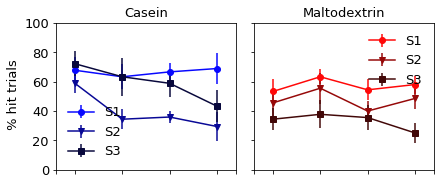

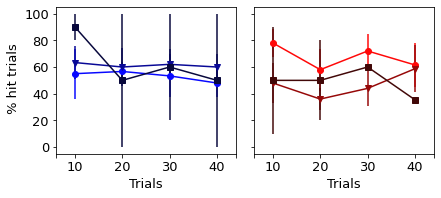

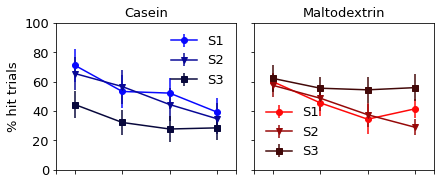

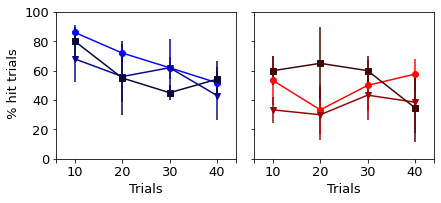

In [77]:
#PR - PRNR

f1, [ax1,ax2] = plt.subplots(figsize=[7,3],ncols=2, gridspec_kw={'wspace':0.1,'width_ratios':[10,10]}, sharey=True)
f1.subplots_adjust(wspace=0.15,hspace=0.35, bottom=0.2, left=0.15)
x=[1,2,3,4]

colors_C=['#0808FF','#080896','#08083C','#FF0808','#960808','#420808']

ax1.errorbar(x, Cas_PR_S1_m, yerr=Cas_PR_S1_E, fmt="-o", color='#0808FF')
ax1.errorbar(x, Cas_PR_S2_m, yerr=Cas_PR_S2_E, fmt="-v", color='#080896')
ax1.errorbar(x, Cas_PR_S3_m, yerr=Cas_PR_S3_E, fmt="-s", color='#08083C')


ax2.errorbar(x, malt_PR_S1_m, yerr=malt_PR_S1_E, fmt="-o", color='#FF0808')
ax2.errorbar(x, malt_PR_S2_m, yerr=malt_PR_S2_E, fmt="-v", color='#960808')
ax2.errorbar(x, malt_PR_S3_m, yerr=malt_PR_S3_E, fmt="-s", color='#420808')

ax1.set_title('Casein',fontsize=13)
ax2.set_title('Maltodextrin',fontsize=13)

ax1.set_ylabel(' % hit trials',fontsize = 13)



ax1.set_yticks([0,20,40,60,80,100])
ax2.set_yticks([0,20,40,60,80,100])
ax1.set_yticklabels([0, 20,40,60,80,100],fontsize=13)
ax1.set_xticks([0.6,1,2,3,4,4.4])
ax2.set_xticks([0.6,1,2,3,4,4.4])
ax1.set_xticklabels([], fontsize=0)
ax2.set_xticklabels([], fontsize=0)

ax1.legend(['S1','S2','S3'], fontsize=13,frameon = False)
ax2.legend(['S1','S2','S3'], fontsize=13,frameon = False)





f2, [ax1,ax2] = plt.subplots(figsize=[7,3],ncols=2, gridspec_kw={'wspace':0.1,'width_ratios':[10,10]}, sharey=True)
f2.subplots_adjust(wspace=0.15,hspace=0.35, bottom=0.2,left=0.15)
x=[1,2,3,4]


ax1.errorbar(x, Cas_PRNR_S1_m, yerr=Cas_PRNR_S1_E, fmt="-o", color='#0808FF')
ax1.errorbar(x, Cas_PRNR_S2_m, yerr=Cas_PRNR_S2_E, fmt="-v", color='#080896')
ax1.errorbar(x, Cas_PRNR_S3_m, yerr=Cas_PRNR_S3_E, fmt="-s", color='#08083C')


ax2.errorbar(x, malt_PRNR_S1_m, yerr=malt_PRNR_S1_E, fmt="-o", color='#FF0808')
ax2.errorbar(x, malt_PRNR_S2_m, yerr=malt_PRNR_S2_E, fmt="-v", color='#960808')
ax2.errorbar(x, malt_PRNR_S3_m, yerr=malt_PRNR_S3_E, fmt="-s", color='#420808')



ax1.set_ylabel(' % hit trials',fontsize = 13)

ax1.set_xlabel('Trials', fontsize = 13)
ax2.set_xlabel('Trials', fontsize = 13)

ax1.set_yticks([0,20,40,60,80,100])
ax2.set_yticks([0,20,40,60,80,100])
ax1.set_yticklabels([0,20,40,60,80,100],fontsize=13)
ax1.set_xticks([0.6,1,2,3,4,4.4])
ax2.set_xticks([0.6,1,2,3,4,4.4])
ax1.set_xticklabels([' ','10','20','30','40', ''], fontsize=13)
ax2.set_xticklabels([' ','10','20','30','40', ''], fontsize=13)


# f1.savefig('C:\\Users\\mko102\\GitHub\\VGP\\output\\hitsPR.png')
# f2.savefig('C:\\Users\\mko102\\GitHub\\VGP\\output\\hitsPRNR.png')


#------------------------------------------------------------------------
#NR- NRPR

f3, [ax1,ax2] = plt.subplots(figsize=[7,3],ncols=2, gridspec_kw={'wspace':0.1,'width_ratios':[10,10]}, sharey=True)
f3.subplots_adjust(wspace=0.15,hspace=0.35, bottom=0.2, left=0.15)
x=[1,2,3,4]

colors_C=['#0808FF','#080896','#08083C','#FF0808','#960808','#420808']

ax1.errorbar(x, Cas_NR_S1_m, yerr=Cas_NR_S1_E, fmt="-o", color='#0808FF')
ax1.errorbar(x, Cas_NR_S2_m, yerr=Cas_NR_S2_E, fmt="-v", color='#080896')
ax1.errorbar(x, Cas_NR_S3_m, yerr=Cas_NR_S3_E, fmt="-s", color='#08083C')


ax2.errorbar(x, malt_NR_S1_m, yerr=malt_NR_S1_E, fmt="-o", color='#FF0808')
ax2.errorbar(x, malt_NR_S2_m, yerr=malt_NR_S2_E, fmt="-v", color='#960808')
ax2.errorbar(x, malt_NR_S3_m, yerr=malt_NR_S3_E, fmt="-s", color='#420808')

ax1.set_title('Casein',fontsize=13)
ax2.set_title('Maltodextrin',fontsize=13)

ax1.set_ylabel('% hit trials',fontsize = 13)



ax1.set_yticks([0,20,40,60,80,100])
ax2.set_yticks([0,20,40,60,80,100])
ax1.set_yticklabels([0,20,40,60,80,100],fontsize=13)
ax1.set_xticks([0.6,1,2,3,4,4.4])
ax2.set_xticks([0.6,1,2,3,4,4.4])
ax1.set_xticklabels([], fontsize=0)
ax2.set_xticklabels([], fontsize=0)

ax1.legend(['S1','S2','S3'], fontsize=13,frameon = False)
ax2.legend(['S1','S2','S3'], fontsize=13,frameon = False)





f4, [ax1,ax2] = plt.subplots(figsize=[7,3],ncols=2, gridspec_kw={'wspace':0.1,'width_ratios':[10,10]}, sharey=True)
f4.subplots_adjust(wspace=0.15,hspace=0.35, bottom=0.2,left=0.15)
x=[1,2,3,4]


ax1.errorbar(x, Cas_NRPR_S1_m, yerr=Cas_NRPR_S1_E, fmt="-o", color='#0808FF')
ax1.errorbar(x, Cas_NRPR_S2_m, yerr=Cas_NRPR_S2_E, fmt="-v", color='#080896')
ax1.errorbar(x, Cas_NRPR_S3_m, yerr=Cas_NRPR_S3_E, fmt="-s", color='#08083C')


ax2.errorbar(x, malt_NRPR_S1_m, yerr=malt_NRPR_S1_E, fmt="-o", color='#FF0808')
ax2.errorbar(x, malt_NRPR_S2_m, yerr=malt_NRPR_S2_E, fmt="-v", color='#960808')
ax2.errorbar(x, malt_NRPR_S3_m, yerr=malt_NRPR_S3_E, fmt="-s", color='#420808')



ax1.set_ylabel(' % hit trials',fontsize = 13)

ax1.set_xlabel('Trials', fontsize = 13)
ax2.set_xlabel('Trials', fontsize = 13)

ax1.set_yticks([0,20,40,60,80,100])
ax2.set_yticks([0,20,40,60,80,100])
ax1.set_yticklabels([0,20,40,60,80,100],fontsize=13)
ax1.set_xticks([0.6,1,2,3,4,4.4])
ax2.set_xticks([0.6,1,2,3,4,4.4])
ax1.set_xticklabels([' ','10','20','30','40', ''], fontsize=13)
ax2.set_xticklabels([' ','10','20','30','40', ''], fontsize=13)


# f3.savefig('C:\\Users\\mko102\\GitHub\\VGP\\output\\hitsNR.png')
# f4.savefig('C:\\Users\\mko102\\GitHub\\VGP\\output\\hitsNRPR.png')

In [38]:
cas_PR_S1,cas_PRNR_S1,cas_NR_S1,cas_NRPR_S1 = grouped_by_session(all_data, 'Cas','S1', '% hit')
cas_PR_S2,cas_PRNR_S2,cas_NR_S2,cas_NRPR_S2 = grouped_by_session(all_data, 'Cas','S2', '% hit')
cas_PR_S3,cas_PRNR_S3,cas_NR_S3,cas_NRPR_S3 = grouped_by_session(all_data, 'Cas','S3', '% hit')

malt_PR_S1,malt_PRNR_S1,malt_NR_S1,malt_NRPR_S1 = grouped_by_session(all_data, 'Malt.','S1', '% hit')
malt_PR_S2,malt_PRNR_S2,malt_NR_S2,malt_NRPR_S2 = grouped_by_session(all_data, 'Malt.','S2', '% hit')
malt_PR_S3,malt_PRNR_S3,malt_NR_S3,malt_NRPR_S3 = grouped_by_session(all_data, 'Malt.','S3', '% hit')

Could not space all sets of points.
Could not space all sets of points.
Could not space all sets of points.
Could not space all sets of points.
Could not space all sets of points.
Could not space all sets of points.
Could not space all sets of points.
Could not space all sets of points.
Could not space all sets of points.
Could not space all sets of points.
Could not space all sets of points.
Could not space all sets of points.
Could not space all sets of points.
Could not space all sets of points.
Could not space all sets of points.
Could not space all sets of points.
Could not space all sets of points.
Could not space all sets of points.
Could not space all sets of points.
Could not space all sets of points.
Could not space all sets of points.
Could not space all sets of points.
Could not space all sets of points.
Could not space all sets of points.


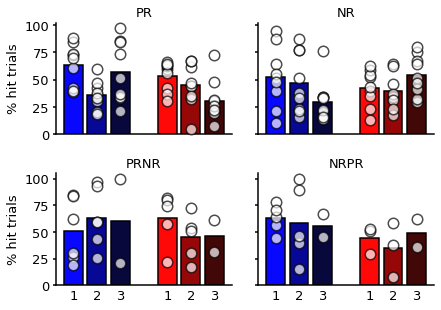

In [41]:
f,ax=plt.subplots(figsize=(7,5), ncols=2, nrows=2, sharey='row')
f.subplots_adjust(wspace=0.15,hspace=0.35, bottom=0.15, left=0.15)

colors_C=['#0808FF','#080896','#08083C','#FF0808','#960808','#420808']


ax[0,0]= make_barscatter([[cas_PR_S1,cas_PR_S2,cas_PR_S3],[malt_PR_S1,malt_PR_S2,malt_PR_S3]], ax=ax[0,0], barfacecolor=colors_C)
ax[1,0]= make_barscatter([[cas_PRNR_S1,cas_PRNR_S2,cas_PRNR_S3],[malt_PRNR_S1,malt_PRNR_S2,malt_PRNR_S3]], ax=ax[1,0], barfacecolor=colors_C,barlabels=['1','2','3','1','2','3'])



ax[0,1]= make_barscatter([[cas_NR_S1,cas_NR_S2,cas_NR_S3],[malt_NR_S1,malt_NR_S2,malt_NR_S3]], ax=ax[0,1], barfacecolor=colors_C)
ax[1,1]= make_barscatter([[cas_NRPR_S1,cas_NRPR_S2,cas_NRPR_S3],[malt_NRPR_S1,malt_NRPR_S2,malt_NRPR_S3]], ax=ax[1,1], barfacecolor=colors_C,barlabels=['1','2','3','1','2','3'])



ax[0,0].set_ylabel('% hit trials',fontsize = 13)
ax[0,0].set_yticks([0,25,50,75,100])
ax[0,1].set_yticks([0,25,50,75,100])
ax[0,0].set_yticklabels([0,25,50,75,100], fontsize = 13)

ax[1,0].set_ylabel('% hit trials',fontsize = 13)
ax[1,0].set_yticks([0,25,50,75,100])
ax[1,1].set_yticks([0,25,50,75,100])
ax[1,0].set_yticklabels([0,25,50,75,100], fontsize = 13)

ax[0,0].set_title('PR',fontsize=13)
ax[0,1].set_title('NR',fontsize=13)
ax[1,0].set_title('PRNR',fontsize=13)
ax[1,1].set_title('NRPR',fontsize=13)






f.savefig('C:\\Users\\mko102\\GitHub\\VGP\\output\\hit_%_session_cm.png')

## Latency to first lick

## latency session

In [46]:
def get_grouped_latencybin(diet,solution, session):

    bin1=[]
    bin2=[]
    bin3=[]
    bin4=[]

    for key in all_data.keys():
        d=all_data[key]
        if d['solution']== solution and d['diet'] == diet and d['session'] == session and len(d['pump_fn']) > 30: 
            if d['latency1'] > 0:
                bin1.append(d['latency1'])
            if d['latency2'] > 0:
                bin2.append(d['latency2'])
            if d['latency3'] > 0:
                bin3.append(d['latency3'])
            if d['latency4'] > 0:
                bin4.append(d['latency4'])
        


    b1_m=np.mean(bin1)
    b1_E=np.std(bin1, ddof=1) / np.sqrt(np.size(bin1))
    b2_m=np.mean(bin2)
    b2_E=np.std(bin2, ddof=1) / np.sqrt(np.size(bin2))
    b3_m=np.mean(bin3)
    b3_E=np.std(bin3, ddof=1) / np.sqrt(np.size(bin3))
    b4_m=np.mean(bin4)
    b4_E=np.std(bin4, ddof=1) / np.sqrt(np.size(bin4))
    
    mean=[b1_m,b2_m,b3_m,b4_m]
    error=[b1_E,b2_E,b3_E,b4_E]
    
    
    return mean,error
    

In [81]:
# Casein PR 
Cas_PR_S1_m, Cas_PR_S1_E= get_grouped_latencybin('PR','Cas','S1')
Cas_PR_S2_m, Cas_PR_S2_E= get_grouped_latencybin('PR','Cas','S2')
Cas_PR_S3_m, Cas_PR_S3_E= get_grouped_latencybin('PR','Cas','S3')

# maltodextrin PR 
malt_PR_S1_m, malt_PR_S1_E= get_grouped_latencybin('PR','Malt.','S1')
malt_PR_S2_m, malt_PR_S2_E= get_grouped_latencybin('PR','Malt.','S2')
malt_PR_S3_m, malt_PR_S3_E= get_grouped_latencybin('PR','Malt.','S3')

# Casein PRNR 
Cas_PRNR_S1_m, Cas_PRNR_S1_E= get_grouped_latencybin('PRNR','Cas','S1')
Cas_PRNR_S2_m, Cas_PRNR_S2_E= get_grouped_latencybin('PRNR','Cas','S2')
Cas_PRNR_S3_m, Cas_PRNR_S3_E= get_grouped_latencybin('PRNR','Cas','S3')

# maltodextrin PRNR 
malt_PRNR_S1_m, malt_PRNR_S1_E= get_grouped_latencybin('PRNR','Malt.','S1')
malt_PRNR_S2_m, malt_PRNR_S2_E= get_grouped_latencybin('PRNR','Malt.','S2')
malt_PRNR_S3_m, malt_PRNR_S3_E= get_grouped_latencybin('PRNR','Malt.','S3')


# KOOL-AID
# Casein PAIRED PR 
CasP_PR_S1_m, CasP_PR_S1_E= get_grouped_latencybin('PR','ppaired','S1')
CasP_PR_S2_m, CasP_PR_S2_E= get_grouped_latencybin('PR','ppaired','S2')
CasP_PR_S3_m, CasP_PR_S3_E= get_grouped_latencybin('PR','ppaired','S3')

# maltodextrin PAIRED PR 
maltP_PR_S1_m, maltP_PR_S1_E= get_grouped_latencybin('PR','mpaired','S1')
maltP_PR_S2_m, maltP_PR_S2_E= get_grouped_latencybin('PR','mpaired','S2')
maltP_PR_S3_m, maltP_PR_S3_E= get_grouped_latencybin('PR','mpaired','S3')

# Casein PARIED PRNR 
CasP_PRNR_S1_m, CasP_PRNR_S1_E= get_grouped_latencybin('PRNR','ppaired','S1')
CasP_PRNR_S2_m, CasP_PRNR_S2_E= get_grouped_latencybin('PRNR','ppaired','S2')
CasP_PRNR_S3_m, CasP_PRNR_S3_E= get_grouped_latencybin('PRNR','ppaired','S3')

# maltodextrin PAIRED PRNR 
maltP_PRNR_S1_m, maltP_PRNR_S1_E= get_grouped_latencybin('PRNR','mpaired','S1')
maltP_PRNR_S2_m, maltP_PRNR_S2_E= get_grouped_latencybin('PRNR','mpaired','S2')
maltP_PRNR_S3_m, maltP_PRNR_S3_E= get_grouped_latencybin('PRNR','mpaired','S3')

In [82]:
# Casein NR 
Cas_NR_S1_m, Cas_NR_S1_E= get_grouped_latencybin('NR','Cas','S1')
Cas_NR_S2_m, Cas_NR_S2_E= get_grouped_latencybin('NR','Cas','S2')
Cas_NR_S3_m, Cas_NR_S3_E= get_grouped_latencybin('NR','Cas','S3')

# maltodextrin NR 
malt_NR_S1_m, malt_NR_S1_E= get_grouped_latencybin('NR','Malt.','S1')
malt_NR_S2_m, malt_NR_S2_E= get_grouped_latencybin('NR','Malt.','S2')
malt_NR_S3_m, malt_NR_S3_E= get_grouped_latencybin('NR','Malt.','S3')

# Casein NRPR 
Cas_NRPR_S1_m, Cas_NRPR_S1_E= get_grouped_latencybin('NRPR','Cas','S1')
Cas_NRPR_S2_m, Cas_NRPR_S2_E= get_grouped_latencybin('NRPR','Cas','S2')
Cas_NRPR_S3_m, Cas_NRPR_S3_E= get_grouped_latencybin('NRPR','Cas','S3')

# maltodextrin NRPR 
malt_NRPR_S1_m, malt_NRPR_S1_E= get_grouped_latencybin('NRPR','Malt.','S1')
malt_NRPR_S2_m, malt_NRPR_S2_E= get_grouped_latencybin('NRPR','Malt.','S2')
malt_NRPR_S3_m, malt_NRPR_S3_E= get_grouped_latencybin('NRPR','Malt.','S3')

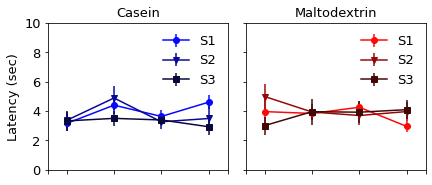

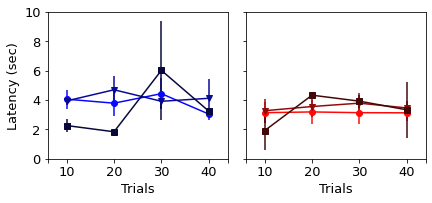

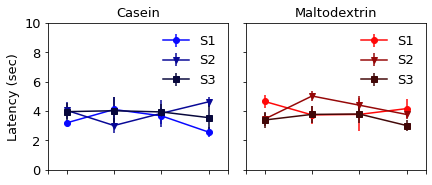

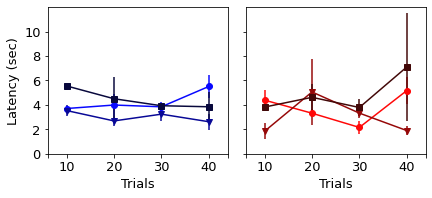

In [83]:
f1, [ax1,ax2] = plt.subplots(figsize=[7,3],ncols=2, gridspec_kw={'wspace':0.1,'width_ratios':[10,10]}, sharey=True)
f1.subplots_adjust(wspace=0.15,hspace=0.35, bottom=0.2, left=0.15)
x=[1,2,3,4]


colors_C=['#0808FF','#080896','#08083C','#FF0808','#960808','#420808']

ax1.errorbar(x, Cas_PR_S1_m, yerr=Cas_PR_S1_E, fmt="-o", color='#0808FF')
ax1.errorbar(x, Cas_PR_S2_m, yerr=Cas_PR_S2_E, fmt="-v", color='#080896')
ax1.errorbar(x, Cas_PR_S3_m, yerr=Cas_PR_S3_E, fmt="-s", color='#08083C')


ax2.errorbar(x, malt_PR_S1_m, yerr=malt_PR_S1_E, fmt="-o", color='#FF0808')
ax2.errorbar(x, malt_PR_S2_m, yerr=malt_PR_S2_E, fmt="-v", color='#960808')
ax2.errorbar(x, malt_PR_S3_m, yerr=malt_PR_S3_E, fmt="-s", color='#420808')

ax1.set_title('Casein',fontsize=13)
ax2.set_title('Maltodextrin',fontsize=13)

ax1.set_ylabel('Latency (sec)',fontsize = 13)



ax1.set_yticks([0,20,40,60,80,100])
ax2.set_yticks([0,20,40,60,80,100])
ax1.set_yticklabels([0,2,4,6,8,10],fontsize=13)
ax1.set_xticks([0.6,1,2,3,4,4.4])
ax2.set_xticks([0.6,1,2,3,4,4.4])
ax1.set_xticklabels([], fontsize=0)
ax2.set_xticklabels([], fontsize=0)

ax1.legend(['S1','S2','S3'], fontsize=13,frameon = False)
ax2.legend(['S1','S2','S3'], fontsize=13,frameon = False)





f2, [ax1,ax2] = plt.subplots(figsize=[7,3],ncols=2, gridspec_kw={'wspace':0.1,'width_ratios':[10,10]}, sharey=True)
f2.subplots_adjust(wspace=0.15,hspace=0.35, bottom=0.2,left=0.15)
x=[1,2,3,4]


ax1.errorbar(x, Cas_PRNR_S1_m, yerr=Cas_PRNR_S1_E, fmt="-o", color='#0808FF')
ax1.errorbar(x, Cas_PRNR_S2_m, yerr=Cas_PRNR_S2_E, fmt="-v", color='#080896')
ax1.errorbar(x, Cas_PRNR_S3_m, yerr=Cas_PRNR_S3_E, fmt="-s", color='#08083C')


ax2.errorbar(x, malt_PRNR_S1_m, yerr=malt_PRNR_S1_E, fmt="-o", color='#FF0808')
ax2.errorbar(x, malt_PRNR_S2_m, yerr=malt_PRNR_S2_E, fmt="-v", color='#960808')
ax2.errorbar(x, malt_PRNR_S3_m, yerr=malt_PRNR_S3_E, fmt="-s", color='#420808')



ax1.set_ylabel('Latency (sec)',fontsize = 13)

ax1.set_xlabel('Trials', fontsize = 13)
ax2.set_xlabel('Trials', fontsize = 13)

ax1.set_yticks([0,20,40,60,80,100])
ax2.set_yticks([0,20,40,60,80,100])
ax1.set_yticklabels([0,2,4,6,8,10],fontsize=13)
ax1.set_xticks([0.6,1,2,3,4,4.4])
ax2.set_xticks([0.6,1,2,3,4,4.4])
ax1.set_xticklabels([' ','10','20','30','40', ''], fontsize=13)
ax2.set_xticklabels([' ','10','20','30','40', ''], fontsize=13)


f1.savefig('C:\\Users\\mko102\\GitHub\\VGP\\output\\LatencyPR.png')
f2.savefig('C:\\Users\\mko102\\GitHub\\VGP\\output\\latencyPRNR.png')


#---------------------------------------------------------------------------------------------------------------------------------------------------------------------
#NR - NRPR

f3, [ax1,ax2] = plt.subplots(figsize=[7,3],ncols=2, gridspec_kw={'wspace':0.1,'width_ratios':[10,10]}, sharey=True)
f3.subplots_adjust(wspace=0.15,hspace=0.35, bottom=0.2, left=0.15)
x=[1,2,3,4]

colors_C=['#0808FF','#080896','#08083C','#FF0808','#960808','#420808']

ax1.errorbar(x, Cas_NR_S1_m, yerr=Cas_NR_S1_E, fmt="-o", color='#0808FF')
ax1.errorbar(x, Cas_NR_S2_m, yerr=Cas_NR_S2_E, fmt="-v", color='#080896')
ax1.errorbar(x, Cas_NR_S3_m, yerr=Cas_NR_S3_E, fmt="-s", color='#08083C')


ax2.errorbar(x, malt_NR_S1_m, yerr=malt_NR_S1_E, fmt="-o", color='#FF0808')
ax2.errorbar(x, malt_NR_S2_m, yerr=malt_NR_S2_E, fmt="-v", color='#960808')
ax2.errorbar(x, malt_NR_S3_m, yerr=malt_NR_S3_E, fmt="-s", color='#420808')

ax1.set_title('Casein',fontsize=13)
ax2.set_title('Maltodextrin',fontsize=13)

ax1.set_ylabel('Latency (sec)',fontsize = 13)



ax1.set_yticks([0,20,40,60,80,100])
ax2.set_yticks([0,20,40,60,80,100])
ax1.set_yticklabels([0,2,4,6,8,10],fontsize=13)
ax1.set_xticks([0.6,1,2,3,4,4.4])
ax2.set_xticks([0.6,1,2,3,4,4.4])
ax1.set_xticklabels([], fontsize=0)
ax2.set_xticklabels([], fontsize=0)

ax1.legend(['S1','S2','S3'], fontsize=13,frameon = False)
ax2.legend(['S1','S2','S3'], fontsize=13,frameon = False)





f4, [ax1,ax2] = plt.subplots(figsize=[7,3],ncols=2, gridspec_kw={'wspace':0.1,'width_ratios':[10,10]}, sharey=True)
f4.subplots_adjust(wspace=0.15,hspace=0.35, bottom=0.2,left=0.15)
x=[1,2,3,4]


ax1.errorbar(x, Cas_NRPR_S1_m, yerr=Cas_NRPR_S1_E, fmt="-o", color='#0808FF')
ax1.errorbar(x, Cas_NRPR_S2_m, yerr=Cas_NRPR_S2_E, fmt="-v", color='#080896')
ax1.errorbar(x, Cas_NRPR_S3_m, yerr=Cas_NRPR_S3_E, fmt="-s", color='#08083C')


ax2.errorbar(x, malt_NRPR_S1_m, yerr=malt_NRPR_S1_E, fmt="-o", color='#FF0808')
ax2.errorbar(x, malt_NRPR_S2_m, yerr=malt_NRPR_S2_E, fmt="-v", color='#960808')
ax2.errorbar(x, malt_NRPR_S3_m, yerr=malt_NRPR_S3_E, fmt="-s", color='#420808')



ax1.set_ylabel('Latency (sec)',fontsize = 13)

ax1.set_xlabel('Trials', fontsize = 13)
ax2.set_xlabel('Trials', fontsize = 13)

ax1.set_yticks([0,20,40,60,80,100])
ax2.set_yticks([0,20,40,60,80,100])
ax1.set_yticklabels([0,2,4,6,8,10],fontsize=13)
ax1.set_xticks([0.6,1,2,3,4,4.4])
ax2.set_xticks([0.6,1,2,3,4,4.4])
ax1.set_xticklabels([' ','10','20','30','40', ''], fontsize=13)
ax2.set_xticklabels([' ','10','20','30','40', ''], fontsize=13)


f3.savefig('C:\\Users\\mko102\\GitHub\\VGP\\output\\LatencyNR.png')
f4.savefig('C:\\Users\\mko102\\GitHub\\VGP\\output\\latencyNRPR.png')

In [51]:
cas_PR_S1,cas_PRNR_S1,cas_NR_S1,cas_NRPR_S1 = grouped_by_session(all_data, 'Cas','S1', 'latency')
cas_PR_S2,cas_PRNR_S2,cas_NR_S2,cas_NRPR_S2 = grouped_by_session(all_data, 'Cas','S2', 'latency')
cas_PR_S3,cas_PRNR_S3,cas_NR_S3,cas_NRPR_S3 = grouped_by_session(all_data, 'Cas','S3', 'latency')

malt_PR_S1,malt_PRNR_S1,malt_NR_S1,malt_NRPR_S1 = grouped_by_session(all_data, 'Malt.','S1', 'latency')
malt_PR_S2,malt_PRNR_S2,malt_NR_S2,malt_NRPR_S2 = grouped_by_session(all_data, 'Malt.','S2', 'latency')
malt_PR_S3,malt_PRNR_S3,malt_NR_S3,malt_NRPR_S3 = grouped_by_session(all_data, 'Malt.','S3', 'latency')

Could not space all sets of points.
Could not space all sets of points.
Could not space all sets of points.
Could not space all sets of points.
Could not space all sets of points.
Could not space all sets of points.
Could not space all sets of points.
Could not space all sets of points.
Could not space all sets of points.
Could not space all sets of points.
Could not space all sets of points.
Could not space all sets of points.
Could not space all sets of points.
Could not space all sets of points.
Could not space all sets of points.
Could not space all sets of points.
Could not space all sets of points.
Could not space all sets of points.
Could not space all sets of points.
Could not space all sets of points.
Could not space all sets of points.
Could not space all sets of points.
Could not space all sets of points.
Could not space all sets of points.


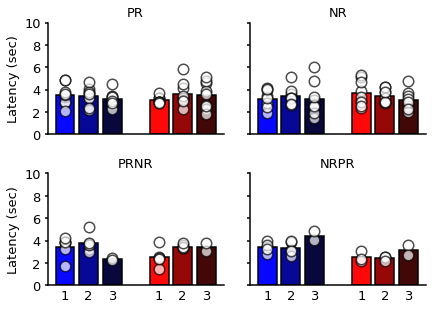

In [52]:
f,ax=plt.subplots(figsize=(7,5), ncols=2, nrows=2, sharey='row')
f.subplots_adjust(wspace=0.15,hspace=0.35, bottom=0.15, left=0.15)

colors_C=['#0808FF','#080896','#08083C','#FF0808','#960808','#420808']


ax[0,0]= make_barscatter([[cas_PR_S1,cas_PR_S2,cas_PR_S3],[malt_PR_S1,malt_PR_S2,malt_PR_S3]], ax=ax[0,0], barfacecolor=colors_C)
ax[1,0]= make_barscatter([[cas_PRNR_S1,cas_PRNR_S2,cas_PRNR_S3],[malt_PRNR_S1,malt_PRNR_S2,malt_PRNR_S3]], ax=ax[1,0], barfacecolor=colors_C,barlabels=['1','2','3','1','2','3'])



ax[0,1]= make_barscatter([[cas_NR_S1,cas_NR_S2,cas_NR_S3],[malt_NR_S1,malt_NR_S2,malt_NR_S3]], ax=ax[0,1], barfacecolor=colors_C)
ax[1,1]= make_barscatter([[cas_NRPR_S1,cas_NRPR_S2,cas_NRPR_S3],[malt_NRPR_S1,malt_NRPR_S2,malt_NRPR_S3]], ax=ax[1,1], barfacecolor=colors_C,barlabels=['1','2','3','1','2','3'])



ax[0,0].set_ylabel('Latency (sec)',fontsize = 13)
ax[0,0].set_yticks([0,20,40,60,80,100])
ax[0,1].set_yticks([0,20,40,60,80,100])
ax[0,0].set_yticklabels([0,2,4,6,8,10], fontsize = 13)

ax[1,0].set_ylabel('Latency (sec)',fontsize = 13)
ax[1,0].set_yticks([0,20,40,60,80,100])
ax[1,1].set_yticks([0,20,40,60,80,100])
ax[1,0].set_yticklabels([0,2,4,6,8,10], fontsize = 13)

ax[0,0].set_title('PR',fontsize=13)
ax[0,1].set_title('NR',fontsize=13)
ax[1,0].set_title('PRNR',fontsize=13)
ax[1,1].set_title('NRPR',fontsize=13)






f.savefig('C:\\Users\\mko102\\GitHub\\VGP\\output\\latency_session_cm.png')

In [53]:
# Casein NR 
Ensure_NR_S1_m, Ensure_NR_S1_E= get_grouped_latencybin('NR','Ensure','S1')
Ensure_NR_S2_m, Ensure_NR_S2_E= get_grouped_latencybin('NR','Ensure','S2')
Ensure_NR_S3_m, Ensure_NR_S3_E= get_grouped_latencybin('NR','Ensure','S3')

# maltodextrin NR 
Ensure_PR_S1_m, Ensure_PR_S1_E= get_grouped_latencybin('PR','Ensure','S1')
Ensure_PR_S2_m, Ensure_PR_S2_E= get_grouped_latencybin('PR','Ensure','S2')
Ensure_PR_S3_m, Ensure_PR_S3_E= get_grouped_latencybin('PR','Ensure','S3')

# Casein NRPR 
Ensure_NRPR_S1_m, Ensure_NRPR_S1_E= get_grouped_latencybin('NRPR','Ensure','S1')
Ensure_NRPR_S2_m, Ensure_NRPR_S2_E= get_grouped_latencybin('NRPR','Ensure','S2')
Ensure_NRPR_S3_m, Ensure_NRPR_S3_E= get_grouped_latencybin('NRPR','Ensure','S3')

# maltodextrin NRPR 
Ensure_PRNR_S1_m, Ensure_PRNR_S1_E= get_grouped_latencybin('PRNR','Ensure','S1')
Ensure_PRNR_S2_m, Ensure_PRNR_S2_E= get_grouped_latencybin('PRNR','Ensure','S2')
Ensure_PRNR_S3_m, Ensure_PRNR_S3_E= get_grouped_latencybin('PRNR','Ensure','S3')

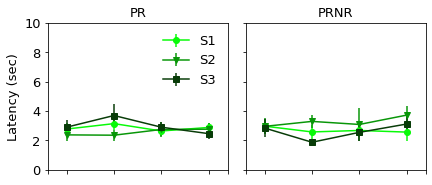

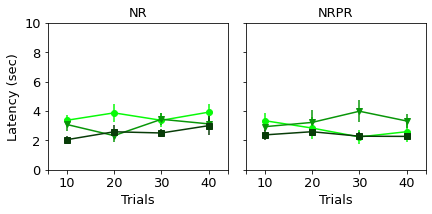

In [54]:
f1, [ax1,ax2] = plt.subplots(figsize=[7,3],ncols=2, gridspec_kw={'wspace':0.1,'width_ratios':[10,10]}, sharey=True)
f1.subplots_adjust(wspace=0.15,hspace=0.35, bottom=0.2, left=0.15)
x=[1,2,3,4]




ax1.errorbar(x, Ensure_PR_S1_m, yerr=Ensure_PR_S1_E, fmt="-o", color='#08FA08')
ax1.errorbar(x, Ensure_PR_S2_m, yerr=Ensure_PR_S2_E, fmt="-v", color='#089608')
ax1.errorbar(x, Ensure_PR_S3_m, yerr=Ensure_PR_S3_E, fmt="-s", color='#083C08')


ax2.errorbar(x, Ensure_PRNR_S1_m, yerr=Ensure_PRNR_S1_E, fmt="-o", color='#08FA08')
ax2.errorbar(x, Ensure_PRNR_S2_m, yerr=Ensure_PRNR_S2_E, fmt="-v", color='#089608')
ax2.errorbar(x, Ensure_PRNR_S3_m, yerr=Ensure_PRNR_S3_E, fmt="-s", color='#083C08')

ax1.set_title('PR',fontsize=13)
ax2.set_title('PRNR',fontsize=13)

ax1.set_ylabel('Latency (sec)',fontsize = 13)



ax1.set_yticks([0,20,40,60,80,100])
ax2.set_yticks([0,20,40,60,80,100])
ax1.set_yticklabels([0,2,4,6,8,10],fontsize=13)
ax1.set_xticks([0.6,1,2,3,4,4.4])
ax2.set_xticks([0.6,1,2,3,4,4.4])
ax1.set_xticklabels([], fontsize=0)
ax2.set_xticklabels([], fontsize=0)

ax1.legend(['S1','S2','S3'], fontsize=13,frameon = False)
# ax2.legend(['S1','S2','S3'], fontsize=13,frameon = False)





f2, [ax1,ax2] = plt.subplots(figsize=[7,3],ncols=2, gridspec_kw={'wspace':0.1,'width_ratios':[10,10]}, sharey=True)
f2.subplots_adjust(wspace=0.15,hspace=0.35, bottom=0.2,left=0.15)
x=[1,2,3,4]


ax1.errorbar(x, Ensure_NR_S1_m, yerr=Ensure_NR_S1_E, fmt="-o", color='#08FA08')
ax1.errorbar(x, Ensure_NR_S2_m, yerr=Ensure_NR_S2_E, fmt="-v", color='#089608')
ax1.errorbar(x, Ensure_NR_S3_m, yerr=Ensure_NR_S3_E, fmt="-s", color='#083C08')


ax2.errorbar(x, Ensure_NRPR_S1_m, yerr=Ensure_NRPR_S1_E, fmt="-o", color='#08FA08')
ax2.errorbar(x, Ensure_NRPR_S2_m, yerr=Ensure_NRPR_S2_E, fmt="-v", color='#089608')
ax2.errorbar(x, Ensure_NRPR_S3_m, yerr=Ensure_NRPR_S3_E, fmt="-s", color='#083C08')

ax1.set_title('NR',fontsize=13)
ax2.set_title('NRPR',fontsize=13)

ax1.set_ylabel('Latency (sec)',fontsize = 13)

ax1.set_xlabel('Trials', fontsize = 13)
ax2.set_xlabel('Trials', fontsize = 13)

ax1.set_yticks([0,20,40,60,80,100])
ax2.set_yticks([0,20,40,60,80,100])
ax1.set_yticklabels([0,2,4,6,8,10],fontsize=13)
ax1.set_xticks([0.6,1,2,3,4,4.4])
ax2.set_xticks([0.6,1,2,3,4,4.4])
ax1.set_xticklabels([' ','10','20','30','40', ''], fontsize=13)
ax2.set_xticklabels([' ','10','20','30','40', ''], fontsize=13)


f1.savefig('C:\\Users\\mko102\\GitHub\\VGP\\output\\LatencyPR_Ensure.png')
f2.savefig('C:\\Users\\mko102\\GitHub\\VGP\\output\\latencyPRNR_Ensure.png')

In [55]:
ensure_PR_S1,ensure_PRNR_S1,ensure_NR_S1,ensure_NRPR_S1 = grouped_by_session(all_data, 'Ensure','S1', 'latency')
ensure_PR_S2,ensure_PRNR_S2,ensure_NR_S2,ensure_NRPR_S2 = grouped_by_session(all_data, 'Ensure','S2', 'latency')
ensure_PR_S3,ensure_PRNR_S3,ensure_NR_S3,ensure_NRPR_S3 = grouped_by_session(all_data, 'Ensure','S3', 'latency')

Could not space all sets of points.
Could not space all sets of points.
Could not space all sets of points.
Could not space all sets of points.
Could not space all sets of points.
Could not space all sets of points.
Could not space all sets of points.
Could not space all sets of points.
Could not space all sets of points.
Could not space all sets of points.
Could not space all sets of points.
Could not space all sets of points.


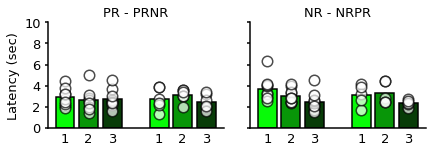

In [56]:
f,ax=plt.subplots(figsize=(7,2), ncols=2, nrows=1, sharey='row')
f.subplots_adjust(wspace=0.15,hspace=0.35, bottom=0.15, left=0.15)

colors_C=['#08FA08','#089608','#083C08','#08FA08','#089608','#083C08']



ax[0]= make_barscatter([[ensure_PR_S1,ensure_PR_S2,ensure_PR_S3],[ensure_PRNR_S1,ensure_PRNR_S2,ensure_PRNR_S3]], ax=ax[0], barfacecolor=colors_C,barlabels=['1','2','3','1','2','3'])
ax[1]= make_barscatter([[ensure_NR_S1,ensure_NR_S2,ensure_NR_S3],[ensure_NRPR_S1,ensure_NRPR_S2,ensure_NRPR_S3]], ax=ax[1], barfacecolor=colors_C,barlabels=['1','2','3','1','2','3'])







ax[0].set_ylabel('Latency (sec)',fontsize = 13)
ax[0].set_yticks([0,20,40,60,80,100])
ax[1].set_yticks([0,20,40,60,80,100])
ax[0].set_yticklabels([0,2,4,6,8,10], fontsize = 13)



ax[0].set_title('PR - PRNR',fontsize=13)
ax[1].set_title('NR - NRPR',fontsize=13)

f.savefig('C:\\Users\\mko102\\GitHub\\VGP\\output\\Latency_session_Ensure.png')

In [57]:
ensure_PR,ensure_PRNR,ensure_NR,ensure_NRPR= get_grouped_data(all_data, 'Ensure', 'latency')
cas_PR,cas_PRNR,cas_NR,cas_NRPR= get_grouped_data(all_data, 'Cas', 'latency')
malt_PR,malt_PRNR,malt_NR,malt_NRPR= get_grouped_data(all_data, 'Malt.', 'latency')

Could not space all sets of points.
Could not space all sets of points.
Could not space all sets of points.
Could not space all sets of points.


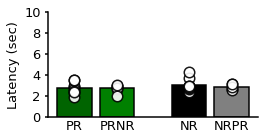

In [58]:
# Figure % hit trial - mean per animal

f,ax=plt.subplots(figsize=(4.5,2), ncols=1, nrows=1, sharey='row')
f.subplots_adjust(wspace=0.15,hspace=0.35, bottom=0.15, left=0.25)

colors_E=['Darkgreen','green','black', 'grey']

tp.barscatter([[ensure_PR,ensure_PRNR],[ensure_NR,ensure_NRPR]], 
#               paired= True,
              barfacecolor=colors_E,
              barfacecolor_option="individual",
              barlabels=['PR', 'PRNR', 'NR', 'NRPR'],
              fontsize = 13,
              scattersize=110,
              scatteralpha=0.9,
              spaced=True,
              linewidth=1.5,
              ax=ax,
              show_legend=False)






ax.set_ylabel('Latency (sec)',fontsize = 13)
ax.set_yticks([0,20,40,60,80,100])
ax.set_yticklabels([0,2,4,6,8,10], fontsize = 13)


# ax.set_title('Ensure', fontsize =13)



f.savefig('C:\\Users\\mko102\\GitHub\\VGP\\output\\Latency_group_ensure.pdf')

Could not space all sets of points.
Could not space all sets of points.
Could not space all sets of points.
Could not space all sets of points.
Could not space all sets of points.
Could not space all sets of points.
Could not space all sets of points.
Could not space all sets of points.


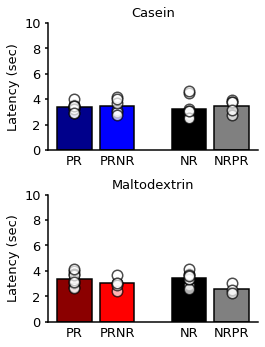

In [59]:
f,ax=plt.subplots(figsize=(4.5,5), ncols=1, nrows=2, sharey='row')
f.subplots_adjust(wspace=0.15,hspace=0.35, bottom=0.05, left=0.25)


colors_C=['darkblue','blue','black', 'grey']
colors_M=['darkred','red','black', 'grey']

ax[0]= make_barscatter([[cas_PR,cas_PRNR],[cas_NR,cas_NRPR]], ax=ax[0],barfacecolor= colors_C)
ax[1] = make_barscatter([[malt_PR,malt_PRNR],[malt_NR,malt_NRPR]], ax=ax[1],barfacecolor= colors_M)



ax[0].set_ylabel('Latency (sec)',fontsize = 13)
ax[0].set_yticks([0,20,40,60,80,100])
ax[0].set_yticklabels([0,2,4,6,8,10], fontsize = 13)

ax[1].set_ylabel('Latency (sec)',fontsize = 13)
ax[1].set_yticks([0,20,40,60,80,100])
ax[1].set_yticklabels([0,2,4,6,8,10], fontsize = 13)


ax[0].set_title('Casein', fontsize =13)
ax[1].set_title('Maltodextrin', fontsize =13)


f.savefig('C:\\Users\\mko102\\GitHub\\VGP\\output\\latency.png')

## CUMULATIVE LICKS   PR - PRNR CAS and MALT CUMULATIVE LICKS

In [69]:
cas_PR_S1=[]
cas_PR_S2=[]
cas_PR_S3=[]

malt_PR_S1=[]
malt_PR_S2=[]
malt_PR_S3=[]

cas_PRNR_S1=[]
cas_PRNR_S2=[]
cas_PRNR_S3=[]

malt_PRNR_S1=[]
malt_PRNR_S2=[]
malt_PRNR_S3=[]
bins=[]


#     temp_NRPR=[]
#     temp_PRNR=[]
    
for key in all_data.keys():
    d=all_data[key]
    if d['solution']=='Cas'and d['diet']== 'PR' and d['session']=='S1':
        cas_PR_S1.append(d['cumulative licks'])
        bins=d['lick bins']
        
    elif d['solution']=='Cas'and d['diet']== 'PR' and d['session']=='S2':
        cas_PR_S2.append(d['cumulative licks'])
        
    elif d['solution']=='Cas'and d['diet']== 'PR' and d['session']=='S3':
        cas_PR_S3.append(d['cumulative licks'])
        
        
        
    elif d['solution']=='Cas'and d['diet']== 'PRNR' and d['session']=='S1':
        cas_PRNR_S1.append(d['cumulative licks'])
    elif d['solution']=='Cas'and d['diet']== 'PRNR' and d['session']=='S2':
        cas_PRNR_S2.append(d['cumulative licks'])
    elif d['solution']=='Cas'and d['diet']== 'PRNR' and d['session']=='S3':
        cas_PRNR_S3.append(d['cumulative licks'])
        
        
    elif d['solution']=='Malt.'and d['diet']== 'PR' and d['session']=='S1':
        malt_PR_S1.append(d['cumulative licks'])
    elif d['solution']=='Malt.'and d['diet']== 'PR' and d['session']=='S2':
        malt_PR_S2.append(d['cumulative licks'])
    elif d['solution']=='Malt.'and d['diet']== 'PR' and d['session']=='S3':
        malt_PR_S3.append(d['cumulative licks'])
        
    elif d['solution']=='Malt.'and d['diet']== 'PRNR' and d['session']=='S1':
        malt_PRNR_S1.append(d['cumulative licks'])
    elif d['solution']=='Malt.'and d['diet']== 'PRNR' and d['session']=='S2':
        malt_PRNR_S2.append(d['cumulative licks'])
    elif d['solution']=='Malt.'and d['diet']== 'PRNR' and d['session']=='S3':
        malt_PRNR_S3.append(d['cumulative licks'])

      
       


## NR - NRPR CAS and MALT CUMULATIVE LICKS

In [70]:
cas_NR_S1=[]
cas_NR_S2=[]
cas_NR_S3=[]

malt_NR_S1=[]
malt_NR_S2=[]
malt_NR_S3=[]

cas_NRPR_S1=[]
cas_NRPR_S2=[]
cas_NRPR_S3=[]

malt_NRPR_S1=[]
malt_NRPR_S2=[]
malt_NRPR_S3=[]
bins=[]


#     temp_NRPR=[]
#     temp_PRNR=[]
    
for key in all_data.keys():
    d=all_data[key]
    if d['solution']=='Cas'and d['diet']== 'NR' and d['session']=='S1':
        cas_NR_S1.append(d['cumulative licks'])
        bins=d['lick bins']
        
    elif d['solution']=='Cas'and d['diet']== 'NR' and d['session']=='S2':
        cas_NR_S2.append(d['cumulative licks'])
        
    elif d['solution']=='Cas'and d['diet']== 'NR' and d['session']=='S3':
        cas_NR_S3.append(d['cumulative licks'])
        
        
        
    elif d['solution']=='Cas'and d['diet']== 'NRPR' and d['session']=='S1':
        cas_NRPR_S1.append(d['cumulative licks'])
    elif d['solution']=='Cas'and d['diet']== 'NRPR' and d['session']=='S2':
        cas_NRPR_S2.append(d['cumulative licks'])
    elif d['solution']=='Cas'and d['diet']== 'NRPR' and d['session']=='S3':
        cas_NRPR_S3.append(d['cumulative licks'])
        
        
    elif d['solution']=='Malt.'and d['diet']== 'NR' and d['session']=='S1':
        malt_NR_S1.append(d['cumulative licks'])
    elif d['solution']=='Malt.'and d['diet']== 'NR' and d['session']=='S2':
        malt_NR_S2.append(d['cumulative licks'])
    elif d['solution']=='Malt.'and d['diet']== 'NR' and d['session']=='S3':
        malt_NR_S3.append(d['cumulative licks'])
        
    elif d['solution']=='Malt.'and d['diet']== 'NRPR' and d['session']=='S1':
        malt_NRPR_S1.append(d['cumulative licks'])
    elif d['solution']=='Malt.'and d['diet']== 'NRPR' and d['session']=='S2':
        malt_NRPR_S2.append(d['cumulative licks'])
    elif d['solution']=='Malt.'and d['diet']== 'NRPR' and d['session']=='S3':
        malt_NRPR_S3.append(d['cumulative licks'])



In [71]:
# # How to put several cols and rows using tp.shadedError


# # gridspec_kw={'wspace':0.1,'width_ratios':[10,15]}
# f2,ax= plt.subplots(figsize=[15,6],ncols=4, nrows=2 , sharey=True)
# f2.subplots_adjust(wspace=0.15,hspace=0.15, bottom=0.2,left=0.15)

# tp.shadedError(ax[0][0],cas_PR_S1, linecolor='#0808FF', linewidth=1.5)
# tp.shadedError(ax[0][0],cas_PR_S2, linecolor='#080896', linewidth=1.5)
# tp.shadedError(ax[0][0],cas_PR_S3, linecolor='#08083C', linewidth=1.5)

# tp.shadedError(ax[0][1],malt_PR_S1, linecolor='#FF0808', linestyle='-', linewidth=1.5)
# tp.shadedError(ax[0][1],malt_PR_S2, linecolor='#960808',linestyle='-', linewidth=1.5)
# tp.shadedError(ax[0][1],malt_PR_S3, linecolor='#420808',linestyle='-', linewidth=1.5)


# tp.shadedError(ax[1][0],cas_PRNR_S1, linecolor='#0808FF', linestyle='-', linewidth=1.5)
# tp.shadedError(ax[1][0],cas_PRNR_S2, linecolor='#080896',linestyle='-', linewidth=1.5)
# tp.shadedError(ax[1][0],cas_PRNR_S3, linecolor='#08083C',linestyle='-', linewidth=1.5)

# tp.shadedError(ax[1][1],malt_PRNR_S1, linecolor='#FF0808', linestyle='-', linewidth=1.5)
# tp.shadedError(ax[1][1],malt_PRNR_S2, linecolor='#960808',linestyle='-', linewidth=1.5)
# tp.shadedError(ax[1][1],malt_PRNR_S3, linecolor='#420808',linestyle='-', linewidth=1.5)

# ax[0][0].set_yticks([0,250,500,750])
# ax[0][0].set_yticklabels([0,250,500,750],fontsize=13)
# ax[1][0].set_yticklabels([0,250,500,750],fontsize=13)
# ax[0][0].set_ylabel('Number of licks\n PR',fontsize = 13)
# ax[1][0].set_ylabel('Number of licks\n PRNR',fontsize = 13)

# ax[0][2].set_ylabel('NR',fontsize = 13)
# ax[1][2].set_ylabel('NRPR',fontsize = 13)


# ax[1][0].set_xticks([0,300, 600,900 ,1200])
# ax[1][1].set_xticks([0,300, 600,900 ,1200])
# ax[0][0].set_xticklabels([], fontsize=13)
# ax[0][1].set_xticklabels([], fontsize=13)
# ax[1][0].set_xticklabels([0,5,10,15,20], fontsize=13)
# ax[1][1].set_xticklabels([0,5,10,15,20], fontsize=13)

# ax[1][0].set_xlabel('Time (min)', fontsize = 13)
# ax[1][1].set_xlabel('Time (min)', fontsize = 13)



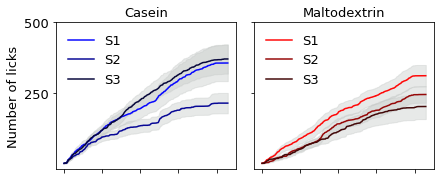

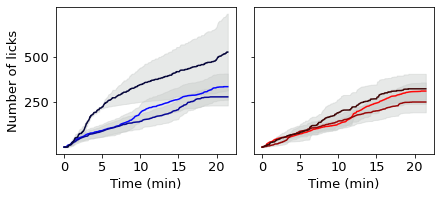

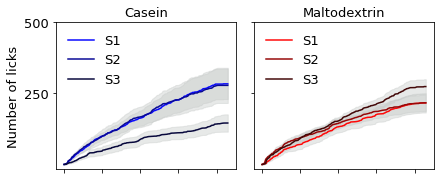

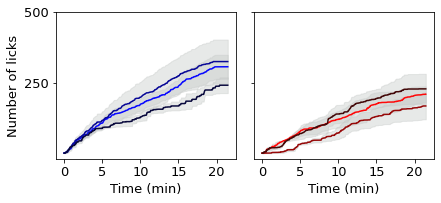

In [74]:
# Making figures PR- PRNR

f1, [ax1,ax2] = plt.subplots(figsize=[7,3],ncols=2, gridspec_kw={'wspace':0.1,'width_ratios':[10,10]}, sharey=True)
f1.subplots_adjust(wspace=0.15,hspace=0.35, bottom=0.2,left=0.15)



     
tp.shadedError(ax1,cas_PR_S1, linecolor='#0808FF', linestyle='-', linewidth=1.5)
tp.shadedError(ax1,cas_PR_S2, linecolor='#080896',linestyle='-', linewidth=1.5)
tp.shadedError(ax1,cas_PR_S3, linecolor='#08083C',linestyle='-', linewidth=1.5)

tp.shadedError(ax2,malt_PR_S1, linecolor='#FF0808', linestyle='-', linewidth=1.5)
tp.shadedError(ax2,malt_PR_S2, linecolor='#960808',linestyle='-', linewidth=1.5)
tp.shadedError(ax2,malt_PR_S3, linecolor='#420808',linestyle='-', linewidth=1.5)

ax1.set_title('Casein',fontsize=13)
ax2.set_title('Maltodextrin',fontsize=13)

ax1.set_ylabel('Number of licks',fontsize = 13)
ax1.legend(['S1','S2','S3'], fontsize=13,frameon = False)
ax2.legend(['S1','S2','S3'], fontsize=13,frameon = False)


ax1.set_yticks([250,500])
ax2.set_yticks([250,500])
ax1.set_yticklabels([250,500],fontsize=13)
ax1.set_xticks([0,300, 600,900 ,1200])
ax2.set_xticks([0,300, 600,900 ,1200])
ax1.set_xticklabels([], fontsize=0)
ax2.set_xticklabels([], fontsize=0)

f2, [ax1,ax2]= plt.subplots(figsize=[7,3],ncols=2, gridspec_kw={'wspace':0.1,'width_ratios':[10,10]}, sharey=True)
f2.subplots_adjust(wspace=0.15,hspace=0.35, bottom=0.2,left=0.15)

tp.shadedError(ax1,cas_PRNR_S1, linecolor='#0808FF', linestyle='-', linewidth=1.5)
tp.shadedError(ax1,cas_PRNR_S2, linecolor='#080896',linestyle='-', linewidth=1.5)
tp.shadedError(ax1,cas_PRNR_S3, linecolor='#08083C',linestyle='-', linewidth=1.5)



tp.shadedError(ax2,malt_PRNR_S1, linecolor='#FF0808', linestyle='-', linewidth=1.5)
tp.shadedError(ax2,malt_PRNR_S2, linecolor='#960808',linestyle='-', linewidth=1.5)
tp.shadedError(ax2,malt_PRNR_S3, linecolor='#420808',linestyle='-', linewidth=1.5)


ax1.set_yticks([250,500])
ax2.set_yticks([250,500])
ax1.set_yticklabels([250,500],fontsize=13)
ax1.set_xticks([0,300, 600,900 ,1200])
ax2.set_xticks([0,300, 600,900 ,1200])
ax1.set_xticklabels([0,5,10,15,20], fontsize=13)
ax2.set_xticklabels([0,5,10,15,20], fontsize=13)

ax1.set_ylabel('Number of licks',fontsize = 13)

ax1.set_xlabel('Time (min)', fontsize = 13)
ax2.set_xlabel('Time (min)', fontsize = 13)


f1.savefig('C:\\Users\\mko102\\GitHub\\VGP\\output\\cumPR.png')
f2.savefig('C:\\Users\\mko102\\GitHub\\VGP\\output\\cumPRNR.png')

# ----------------------------------------------------------------------------------------------------------------------------------

# Making figures NR- NRPR

f3, [ax1,ax2] = plt.subplots(figsize=[7,3],ncols=2, gridspec_kw={'wspace':0.1,'width_ratios':[10,10]}, sharey=True)
f3.subplots_adjust(wspace=0.15,hspace=0.35, bottom=0.2,left=0.15)



     
tp.shadedError(ax1,cas_NR_S1, linecolor='#0808FF', linestyle='-', linewidth=1.5)
tp.shadedError(ax1,cas_NR_S2, linecolor='#080896',linestyle='-', linewidth=1.5)
tp.shadedError(ax1,cas_NR_S3, linecolor='#08083C',linestyle='-', linewidth=1.5)


tp.shadedError(ax2,malt_NR_S1, linecolor='#FF0808', linestyle='-', linewidth=1.5)
tp.shadedError(ax2,malt_NR_S2, linecolor='#960808',linestyle='-', linewidth=1.5)
tp.shadedError(ax2,malt_NR_S3, linecolor='#420808',linestyle='-', linewidth=1.5)

ax1.set_title('Casein',fontsize=13)
ax2.set_title('Maltodextrin',fontsize=13)

ax1.set_ylabel('Number of licks',fontsize = 13)
ax1.legend(['S1','S2','S3'], fontsize=13,frameon = False)
ax2.legend(['S1','S2','S3'], fontsize=13,frameon = False)


ax1.set_yticks([250,500])
ax2.set_yticks([250,500])
ax1.set_yticklabels([250,500],fontsize=13)
ax1.set_xticks([0,300, 600,900 ,1200])
ax2.set_xticks([0,300, 600,900 ,1200])
ax1.set_xticklabels([], fontsize=0)
ax2.set_xticklabels([], fontsize=0)

f4, [ax1,ax2]= plt.subplots(figsize=[7,3],ncols=2, gridspec_kw={'wspace':0.1,'width_ratios':[10,10]}, sharey=True)
f4.subplots_adjust(wspace=0.15,hspace=0.35, bottom=0.2,left=0.15)

tp.shadedError(ax1,cas_NRPR_S1, linecolor='#0808FF', linestyle='-', linewidth=1.5)
tp.shadedError(ax1,cas_NRPR_S2, linecolor='#080896',linestyle='-', linewidth=1.5)
tp.shadedError(ax1,cas_NRPR_S3, linecolor='#08083C',linestyle='-', linewidth=1.5)



tp.shadedError(ax2,malt_NRPR_S1, linecolor='#FF0808', linestyle='-', linewidth=1.5)
tp.shadedError(ax2,malt_NRPR_S2, linecolor='#960808',linestyle='-', linewidth=1.5)
tp.shadedError(ax2,malt_NRPR_S3, linecolor='#420808',linestyle='-', linewidth=1.5)


ax1.set_yticks([250,500])
ax2.set_yticks([250,500])
ax1.set_yticklabels([250,500],fontsize=13)
ax1.set_xticks([0,300, 600,900 ,1200])
ax2.set_xticks([0,300, 600,900 ,1200])
ax1.set_xticklabels([0,5,10,15,20], fontsize=13)
ax2.set_xticklabels([0,5,10,15,20], fontsize=13)

ax1.set_ylabel('Number of licks',fontsize = 13)

ax1.set_xlabel('Time (min)', fontsize = 13)
ax2.set_xlabel('Time (min)', fontsize = 13)


f3.savefig('C:\\Users\\mko102\\GitHub\\VGP\\output\\cumNR.png')
f4.savefig('C:\\Users\\mko102\\GitHub\\VGP\\output\\cumNRPR.png')

## Cumulative licks Kool-Aid IN THE MAKING

In [75]:
pparied_PR=[]
protein_PR=[]
mparied_PR=[]
cas_PR_S3=[]

malt_PR_S1=[]
malt_PR_S2=[]
malt_PR_S3=[]

cas_PRNR_S1=[]
cas_PRNR_S2=[]
cas_PRNR_S3=[]

malt_PRNR_S1=[]
malt_PRNR_S2=[]
malt_PRNR_S3=[]
bins=[]


#     temp_NRPR=[]
#     temp_PRNR=[]
    
for key in all_data.keys():
    d=all_data[key]
    if d['solution']=='ppaired'and d['diet']== 'PR':
        pparied_PR.append(d['cumulative licks'])
        bins=d['lick bins']
        
    elif d['solution']=='Cas'and d['diet']== 'PR':
        protein_PR.append(d['cumulative licks'])
        
    elif d['solution']=='mpaired'and d['diet']== 'PR':
        mparied_PR.append(d['cumulative licks'])
        
#     elif d['solution']=='Cas'and d['diet']== 'PR' and d['session']=='S3':
#         cas_PR_S3.append(d['cumulative licks'])
        
        
        
#     elif d['solution']=='Cas'and d['diet']== 'PRNR' and d['session']=='S1':
#         cas_PRNR_S1.append(d['cumulative licks'])
#     elif d['solution']=='Cas'and d['diet']== 'PRNR' and d['session']=='S2':
#         cas_PRNR_S2.append(d['cumulative licks'])
#     elif d['solution']=='Cas'and d['diet']== 'PRNR' and d['session']=='S3':
#         cas_PRNR_S3.append(d['cumulative licks'])
        
        
#     elif d['solution']=='Malt.'and d['diet']== 'PR' and d['session']=='S1':
#         malt_PR_S1.append(d['cumulative licks'])
#     elif d['solution']=='Malt.'and d['diet']== 'PR' and d['session']=='S2':
#         malt_PR_S2.append(d['cumulative licks'])
#     elif d['solution']=='Malt.'and d['diet']== 'PR' and d['session']=='S3':
#         malt_PR_S3.append(d['cumulative licks'])
        
#     elif d['solution']=='Malt.'and d['diet']== 'PRNR' and d['session']=='S1':
#         malt_PRNR_S1.append(d['cumulative licks'])
#     elif d['solution']=='Malt.'and d['diet']== 'PRNR' and d['session']=='S2':
#         malt_PRNR_S2.append(d['cumulative licks'])
#     elif d['solution']=='Malt.'and d['diet']== 'PRNR' and d['session']=='S3':
#         malt_PRNR_S3.append(d['cumulative licks'])
pparied_PR

[array([  0,   0,   0, ..., 385, 385, 385], dtype=int64),
 array([  0,   0,   0, ..., 126, 126, 126], dtype=int64),
 array([  0,   1,   2, ..., 477, 477, 477], dtype=int64),
 array([  0,   0,   0, ..., 412, 412, 412], dtype=int64),
 array([  2,   2,   2, ..., 277, 277, 277], dtype=int64),
 array([  0,   0,   0, ..., 227, 227, 227], dtype=int64)]

## IN THE MAKING

[Text(0, 0, ''),
 Text(300, 0, ''),
 Text(600, 0, ''),
 Text(900, 0, ''),
 Text(1200, 0, '')]

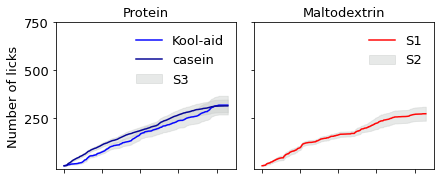

In [76]:
f1, [ax1,ax2] = plt.subplots(figsize=[7,3],ncols=2, gridspec_kw={'wspace':0.1,'width_ratios':[10,10]}, sharey=True)
f1.subplots_adjust(wspace=0.15,hspace=0.35, bottom=0.2,left=0.15)



     
tp.shadedError(ax1,pparied_PR, linecolor='#0808FF', linestyle='-', linewidth=1.5)
tp.shadedError(ax1,protein_PR, linecolor='#080896',linestyle='-', linewidth=1.5)
# tp.shadedError(ax1,cas_PR_S3, linecolor='#08083C',linestyle='-', linewidth=1.5)

tp.shadedError(ax2,mparied_PR, linecolor='#FF0808', linestyle='-', linewidth=1.5)
# tp.shadedError(ax2,malt_PR_S2, linecolor='#960808',linestyle='-', linewidth=1.5)
# tp.shadedError(ax2,malt_PR_S3, linecolor='#420808',linestyle='-', linewidth=1.5)

ax1.set_title('Protein',fontsize=13)
ax2.set_title('Maltodextrin',fontsize=13)

ax1.set_ylabel('Number of licks',fontsize = 13)
ax1.legend(['Kool-aid','casein','S3'], fontsize=13,frameon = False)
ax2.legend(['S1','S2','S3'], fontsize=13,frameon = False)


ax1.set_yticks([250,500,750])
ax2.set_yticks([250,500,750])
ax1.set_yticklabels([250,500,750],fontsize=13)
ax1.set_xticks([0,300, 600,900 ,1200])
ax2.set_xticks([0,300, 600,900 ,1200])
ax1.set_xticklabels([], fontsize=0)
ax2.set_xticklabels([], fontsize=0)

### CUMULATIVE LICKS ENSURE

In [77]:
ensure_PR_S1=[]
ensure_PR_S2=[]
ensure_PR_S3=[]

ensure_NR_S1=[]
ensure_NR_S2=[]
ensure_NR_S3=[]

ensure_PRNR_S1=[]
ensure_PRNR_S2=[]
ensure_PRNR_S3=[]

ensure_NRPR_S1=[]
ensure_NRPR_S2=[]
ensure_NRPR_S3=[]
bins=[]


#     temp_NRPR=[]
#     temp_PRNR=[]
    
for key in all_data.keys():
    d=all_data[key]
    if d['solution']=='Ensure'and d['diet']== 'PR' and d['session']=='S1':
        ensure_PR_S1.append(d['cumulative licks'])
        bins=d['lick bins']
        
    elif d['solution']=='Ensure'and d['diet']== 'PR' and d['session']=='S2':
        ensure_PR_S2.append(d['cumulative licks'])
        
    elif d['solution']=='Ensure'and d['diet']== 'PR' and d['session']=='S3':
        ensure_PR_S3.append(d['cumulative licks'])
        
        
        
    elif d['solution']=='Ensure'and d['diet']== 'NR' and d['session']=='S1':
        ensure_NR_S1.append(d['cumulative licks'])
    elif d['solution']=='Ensure'and d['diet']== 'NR' and d['session']=='S2':
        ensure_NR_S2.append(d['cumulative licks'])
    elif d['solution']=='Ensure'and d['diet']== 'NR' and d['session']=='S3':
        ensure_NR_S3.append(d['cumulative licks'])
        
        
    elif d['solution']=='Ensure'and d['diet']== 'PRNR' and d['session']=='S1':
        ensure_PRNR_S1.append(d['cumulative licks'])
    elif d['solution']=='Ensure'and d['diet']== 'PRNR' and d['session']=='S2':
        ensure_PRNR_S2.append(d['cumulative licks'])
    elif d['solution']=='Ensure'and d['diet']== 'PRNR' and d['session']=='S3':
        ensure_PRNR_S3.append(d['cumulative licks'])
        
    elif d['solution']=='Ensure'and d['diet']== 'NRPR' and d['session']=='S1':
        ensure_NRPR_S1.append(d['cumulative licks'])
    elif d['solution']=='Ensure'and d['diet']== 'NRPR' and d['session']=='S2':
        ensure_NRPR_S2.append(d['cumulative licks'])
    elif d['solution']=='Ensure'and d['diet']== 'NRPR' and d['session']=='S3':
        ensure_NRPR_S3.append(d['cumulative licks'])      

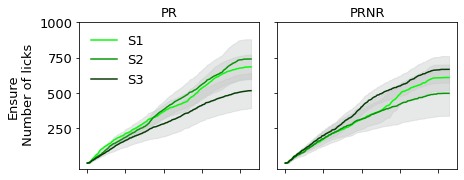

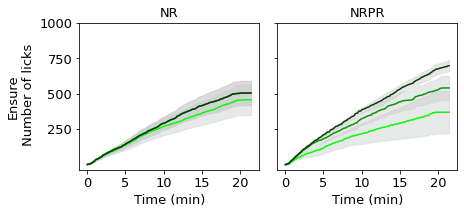

In [78]:
# Making figures PR- PRNR Ensure

f1, [ax1,ax2] = plt.subplots(figsize=[7,3],ncols=2, gridspec_kw={'wspace':0.1,'width_ratios':[10,10]}, sharey=True)
f1.subplots_adjust(wspace=0.15,hspace=0.35, bottom=0.2,left=0.15)


     
tp.shadedError(ax1,ensure_PR_S1, linecolor='#08FA08', linestyle='-', linewidth=1.5)
tp.shadedError(ax1,ensure_PR_S2, linecolor='#089608',linestyle='-', linewidth=1.5)
tp.shadedError(ax1,ensure_PR_S3, linecolor='#083C08',linestyle='-', linewidth=1.5)

tp.shadedError(ax2,ensure_PRNR_S1, linecolor='#08FA08', linestyle='-', linewidth=1.5)
tp.shadedError(ax2,ensure_PRNR_S2, linecolor='#089608',linestyle='-', linewidth=1.5)
tp.shadedError(ax2,ensure_PRNR_S3, linecolor='#083C08',linestyle='-', linewidth=1.5)

ax1.set_title('PR',fontsize=13)
ax2.set_title('PRNR',fontsize=13)

ax1.set_ylabel('Ensure\n Number of licks',fontsize = 13)
ax1.legend(['S1','S2','S3'], fontsize=13,frameon = False)
# ax2.legend(['S1','S2','S3'], fontsize=13,frameon = False)


ax1.set_yticks([250,500,750,1000])
ax2.set_yticks([250,500,750,1000])
ax1.set_yticklabels([250,500,750,1000],fontsize=13)
ax1.set_xticks([0,300, 600,900 ,1200])
ax2.set_xticks([0,300, 600,900 ,1200])
ax1.set_xticklabels([], fontsize=0)
ax2.set_xticklabels([], fontsize=0)

f2, [ax1,ax2]= plt.subplots(figsize=[7,3],ncols=2, gridspec_kw={'wspace':0.1,'width_ratios':[10,10]}, sharey=True)
f2.subplots_adjust(wspace=0.15,hspace=0.35, bottom=0.2,left=0.15)

tp.shadedError(ax1,ensure_NR_S1, linecolor='#08FA08', linestyle='-', linewidth=1.5)
tp.shadedError(ax1,ensure_NR_S2, linecolor='#089608',linestyle='-', linewidth=1.5)
tp.shadedError(ax1,ensure_NR_S2, linecolor='#083C08',linestyle='-', linewidth=1.5)

#08FA08
#089608
#083C08

tp.shadedError(ax2,ensure_NRPR_S1, linecolor='#08FA08', linestyle='-', linewidth=1.5)
tp.shadedError(ax2,ensure_NRPR_S2, linecolor='#089608',linestyle='-', linewidth=1.5)
tp.shadedError(ax2,ensure_NRPR_S3, linecolor='#083C08',linestyle='-', linewidth=1.5)

ax1.set_title('NR',fontsize=13)
ax2.set_title('NRPR',fontsize=13)

ax1.set_yticks([250,500,750,1000])
ax2.set_yticks([250,500,750,1000])
ax1.set_yticklabels([250,500,750,1000],fontsize=13)
ax1.set_xticks([0,300, 600,900 ,1200])
ax2.set_xticks([0,300, 600,900 ,1200])
ax1.set_xticklabels([0,5,10,15,20], fontsize=13)
ax2.set_xticklabels([0,5,10,15,20], fontsize=13)

ax1.set_ylabel('Ensure\n Number of licks',fontsize = 13)

ax1.set_xlabel('Time (min)', fontsize = 13)
ax2.set_xlabel('Time (min)', fontsize = 13)


f1.savefig('C:\\Users\\mko102\\GitHub\\VGP\\output\\cumPREnsure.pdf')
f2.savefig('C:\\Users\\mko102\\GitHub\\VGP\\output\\cumNREnsure.pdf')

## TOTAL LICKS GROUPED BY TRIAL

In [79]:
cas_PR_S1,cas_PRNR_S1,cas_NR_S1,cas_NRPR_S1 = grouped_by_session(all_data, 'Cas','S1', 'total licks')
cas_PR_S2,cas_PRNR_S2,cas_NR_S2,cas_NRPR_S2 = grouped_by_session(all_data, 'Cas','S2', 'total licks')
cas_PR_S3,cas_PRNR_S3,cas_NR_S3,cas_NRPR_S3 = grouped_by_session(all_data, 'Cas','S3', 'total licks')

malt_PR_S1,malt_PRNR_S1,malt_NR_S1,malt_NRPR_S1 = grouped_by_session(all_data, 'Malt.','S1', 'total licks')
malt_PR_S2,malt_PRNR_S2,malt_NR_S2,malt_NRPR_S2 = grouped_by_session(all_data, 'Malt.','S2', 'total licks')
malt_PR_S3,malt_PRNR_S3,malt_NR_S3,malt_NRPR_S3 = grouped_by_session(all_data, 'Malt.','S3', 'total licks')


Could not space all sets of points.
Could not space all sets of points.
Could not space all sets of points.
Could not space all sets of points.
Could not space all sets of points.
Could not space all sets of points.
Could not space all sets of points.
Could not space all sets of points.
Could not space all sets of points.
Could not space all sets of points.
Could not space all sets of points.
Could not space all sets of points.
Could not space all sets of points.
Could not space all sets of points.
Could not space all sets of points.
Could not space all sets of points.
Could not space all sets of points.
Could not space all sets of points.
Could not space all sets of points.
Could not space all sets of points.
Could not space all sets of points.
Could not space all sets of points.
Could not space all sets of points.
Could not space all sets of points.
[211.0, 133.0, 261.0, 509.0, 201.0, 129.0, 604.0, 345.0, 161.0]
[104.0, 155.0, 238.0, 114.0, 417.0, 271.0, 610.0, 530.0, 67.0]
[144.0, 8

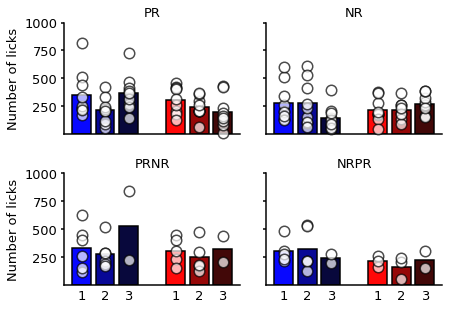

In [80]:
f,ax=plt.subplots(figsize=(7,5), ncols=2, nrows=2, sharey='row')
f.subplots_adjust(wspace=0.15,hspace=0.35, bottom=0.15, left=0.15)

colors_C=['#0808FF','#080896','#08083C','#FF0808','#960808','#420808']


ax[0,0]= make_barscatter([[cas_PR_S1,cas_PR_S2,cas_PR_S3],[malt_PR_S1,malt_PR_S2,malt_PR_S3]], ax=ax[0,0], barfacecolor=colors_C)
ax[1,0]= make_barscatter([[cas_PRNR_S1,cas_PRNR_S2,cas_PRNR_S3],[malt_PRNR_S1,malt_PRNR_S2,malt_PRNR_S3]], ax=ax[1,0], barfacecolor=colors_C,barlabels=['1','2','3','1','2','3'])



ax[0,1]= make_barscatter([[cas_NR_S1,cas_NR_S2,cas_NR_S3],[malt_NR_S1,malt_NR_S2,malt_NR_S3]], ax=ax[0,1], barfacecolor=colors_C)
ax[1,1]= make_barscatter([[cas_NRPR_S1,cas_NRPR_S2,cas_NRPR_S3],[malt_NRPR_S1,malt_NRPR_S2,malt_NRPR_S3]], ax=ax[1,1], barfacecolor=colors_C,barlabels=['1','2','3','1','2','3'])



ax[0,0].set_ylabel('Number of licks',fontsize = 13)
ax[0,0].set_yticks([250,500,750,1000])
ax[0,1].set_yticks([250,500,750,1000])
ax[0,0].set_yticklabels([250,500,750,1000], fontsize = 13)

ax[1,0].set_ylabel('Number of licks',fontsize = 13)
ax[1,0].set_yticks([250,500,750,1000])
ax[1,1].set_yticks([250,500,750,1000])
ax[1,0].set_yticklabels([250,500,750,1000], fontsize = 13)

ax[0,0].set_title('PR',fontsize=13)
ax[0,1].set_title('NR',fontsize=13)
ax[1,0].set_title('PRNR',fontsize=13)
ax[1,1].set_title('NRPR',fontsize=13)


print(cas_NR_S1)
print(cas_NR_S2)
print(cas_NR_S3)
f.savefig('C:\\Users\\mko102\\GitHub\\VGP\\output\\total_licks_session.png')

In [81]:
ensure_PR_S1,ensure_PRNR_S1,ensure_NR_S1,ensure_NRPR_S1 = grouped_by_session(all_data, 'Ensure','S1', 'total licks')
ensure_PR_S2,ensure_PRNR_S2,ensure_NR_S2,ensure_NRPR_S2 = grouped_by_session(all_data, 'Ensure','S2', 'total licks')
ensure_PR_S3,ensure_PRNR_S3,ensure_NR_S3,ensure_NRPR_S3 = grouped_by_session(all_data, 'Ensure','S3', 'total licks')

Could not space all sets of points.
Could not space all sets of points.
Could not space all sets of points.
Could not space all sets of points.
Could not space all sets of points.
Could not space all sets of points.
Could not space all sets of points.
Could not space all sets of points.
Could not space all sets of points.
Could not space all sets of points.
Could not space all sets of points.
Could not space all sets of points.


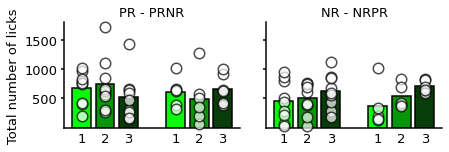

In [82]:
f,ax=plt.subplots(figsize=(7,2), ncols=2, nrows=1, sharey='row')
f.subplots_adjust(wspace=0.15,hspace=0.35, bottom=0.15, left=0.15)

colors_C=['#08FA08','#089608','#083C08','#08FA08','#089608','#083C08']



ax[0]= make_barscatter([[ensure_PR_S1,ensure_PR_S2,ensure_PR_S3],[ensure_PRNR_S1,ensure_PRNR_S2,ensure_PRNR_S3]], ax=ax[0], barfacecolor=colors_C,barlabels=['1','2','3','1','2','3'])
ax[1]= make_barscatter([[ensure_NR_S1,ensure_NR_S2,ensure_NR_S3],[ensure_NRPR_S1,ensure_NRPR_S2,ensure_NRPR_S3]], ax=ax[1], barfacecolor=colors_C,barlabels=['1','2','3','1','2','3'])







ax[0].set_ylabel('Total number of licks',fontsize = 13)
ax[0].set_yticks([500,1000,1500])
ax[1].set_yticks([500,1000,1500])
ax[0].set_yticklabels([500,1000,1500], fontsize = 13)



ax[0].set_title('PR - PRNR',fontsize=13)
ax[1].set_title('NR - NRPR',fontsize=13)

f.savefig('C:\\Users\\mko102\\GitHub\\VGP\\output\\total_licks_session_Ensure.png')
